# Title

Pada kesempatan talent fair ini, saya akan melakukan forecast terhadapat dataset kalbe yang sudah perusahaan Kalbe sediakan.
Kita akan melakukan forecast selama 14 hari setelah hari ke-90 pada produk A1, A2, B1, dan B2.

# Introduction

Nama : Edwin Reyhan Devara Ramadhan Rasya  
Batch : FTDS-017-RMT

Penulis sudah menjalani 3 bulan bootcamp data science bersama Hacktiv8 secara remote.  
Untuk mengakhiri bootcamp, penulis akan mengerjakan dataset kalbe untuk final project.

# External Link

Deployment Link : https://huggingface.co/spaces/edwinrdrr/kalbe_forecast

# Working Area

## Import Libraries

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from sklearn.model_selection import ParameterGrid
import datetime
from statsmodels.tools.eval_measures import rmse

## Loading data

In [142]:
raw_data_a1 = pd.read_excel(open('kalbe_data/kalbe_data.xlsx', 'rb'), sheet_name='A1')

In [143]:
raw_data_a2 = pd.read_excel(open('kalbe_data/kalbe_data.xlsx', 'rb'), sheet_name='A2')

In [144]:
raw_data_b1 = pd.read_excel(open('kalbe_data/kalbe_data.xlsx', 'rb'), sheet_name='B1')

In [145]:
raw_data_b2 = pd.read_excel(open('kalbe_data/kalbe_data.xlsx', 'rb'), sheet_name='B2')

## Data Preprocessing

In [146]:
data_a1 = raw_data_a1.copy()
data_a2 = raw_data_a2.copy()
data_b1 = raw_data_b1.copy()
data_b2 = raw_data_b2.copy()

### Check Missing Value

In [147]:
data_a1.isna().sum()

Day         0
Category    0
Product     0
Sales       0
dtype: int64

In [148]:
data_a2.isna().sum()

Day         0
Category    0
Product     0
Sales       0
dtype: int64

In [149]:
data_b1.isna().sum()

Day          0
Category     0
Product      0
Sales       14
Event        0
dtype: int64

Data produk B1 ada 14 missing values di Sales, mari kita lihat dimana saja missing valuenya.

In [150]:
data_b1[data_b1.Sales.isna()]

,Day,Category,Product,Sales,Event
90,91,B,B1,NaN,0
91,92,B,B1,NaN,0
92,93,B,B1,NaN,0
93,94,B,B1,NaN,1
94,95,B,B1,NaN,0
95,96,B,B1,NaN,0
96,97,B,B1,NaN,0
97,98,B,B1,NaN,0
98,99,B,B1,NaN,0
99,100,B,B1,NaN,0


Kita bisa melihat bahwa data missing value ada pada hari-hari setelah hari 90 atau menurut penulis adalah data 14 hari yang mau diprediksi, Maka dari itu bisa kita drop saja terlebih dahulu.

In [151]:
data_b2.isna().sum()

Day          0
Category     0
Product      0
Sales       74
dtype: int64

Data produk B2 juga memiliki data missing values pada Sales. Mari kita lihat seperti apa. Karena data yang bukan missing value lebih sedikit, maka kita juga akan melihat yang bukan missing value.

In [152]:
data_b2[data_b2.Sales.isna()]

,Day,Category,Product,Sales
0,1,B,B2,NaN
1,2,B,B2,NaN
2,3,B,B2,NaN
3,4,B,B2,NaN
4,5,B,B2,NaN
...,...,...,...,...
99,100,B,B2,NaN
100,101,B,B2,NaN
101,102,B,B2,NaN
102,103,B,B2,NaN


In [153]:
data_b2[~data_b2.Sales.isna()]

,Day,Category,Product,Sales
60,61,B,B2,10.000000
61,62,B,B2,20.000000
62,63,B,B2,40.000000
63,64,B,B2,80.000000
64,65,B,B2,144.000000
65,66,B,B2,259.200000
66,67,B,B2,300.000000
67,68,B,B2,450.000000
68,69,B,B2,560.000000
69,70,B,B2,840.000000


In [154]:
len(data_b2[~data_b2.Sales.isna()])

30

Kita bisa melihat bahwa data sales produk B2 hanya ada 30 hari. Hal ini mungkin menunjukkan bahwa produk B2 adalah produk baru.
Dan data missing value yang ada setelah hari 90 adalah hari-hari yang ingin kita prediksi. Maka dari itu, kita bisa hapus saja missing valuesnya.

### Adding date data to our datasets

Karena penulis ingin menggunakan Facebook Prophet untuk melakukan forecasting, penulis butuh membuat dummy datetime untuk menggantikan data "Day". Hal ini harus dilakukan karena library Prophet tidak dapat melakukan prediksi jika data waktu tidak berbentuk datetime.

Data date yang akan kita buat akan dihitung mundur 90 hari dari tanggal 2022-12-31. Lalu kita bisa melakukan prediksi dari 2023-01-01 sampai 2023-01-14 untuk produk A1, A2, B1, dan B2.

#### Produk A1

In [155]:
# membuat data datetime dengan panjang 90 hari seperti banyannya data dan hari di data_a1
# memberi nama kolom sebagai 'ds', hal ini jadi syarat dari library prophet
data_a1['ds'] = pd.date_range('2022-10-03', '2022-12-31')

In [156]:
# check apakah pembuatan data datetime menghasilkan missing value
data_a1.isna().sum()

Day         0
Category    0
Product     0
Sales       0
ds          0
dtype: int64

In [157]:
data_a1.head(2)

,Day,Category,Product,Sales,ds
0,1,A,A1,100.0,2022-10-03
1,2,A,A1,101.0,2022-10-04


In [158]:
data_a1.tail(2)

,Day,Category,Product,Sales,ds
88,89,A,A1,199.949498,2022-12-30
89,90,A,A1,200.949246,2022-12-31


#### Produk A2

In [159]:
# membuat data datetime dengan panjang 90 hari seperti banyannya data dan hari di data_a2
data_a2['ds'] = pd.date_range('2022-10-03', '2022-12-31')

In [160]:
# check apakah pembuatan data datetime menghasilkan missing value
data_a2.isna().sum()

Day         0
Category    0
Product     0
Sales       0
ds          0
dtype: int64

In [161]:
data_a2.head(2)

,Day,Category,Product,Sales,ds
0,1,A,A2,1000.0,2022-10-03
1,2,A,A2,1005.0,2022-10-04


In [162]:
data_a2.tail(2)

,Day,Category,Product,Sales,ds
88,89,A,A2,1551.005845,2022-12-30
89,90,A,A2,1558.760875,2022-12-31


#### Produk B1

In [163]:
# pertama kita butuh drop missing values
data_b1.dropna(inplace=True)

In [164]:
# membuat data datetime dengan panjang 90 hari seperti banyaknya data dan hari di data_b1
data_b1['ds'] = pd.date_range('2022-10-03', '2022-12-31')

In [165]:
# check apakah pembuatan data datetime menghasilkan missing value
data_b1.isna().sum()

Day         0
Category    0
Product     0
Sales       0
Event       0
ds          0
dtype: int64

In [166]:
data_b1.head(2)

,Day,Category,Product,Sales,Event,ds
0,1,B,B1,990.0,0,2022-10-03
1,2,B,B1,980.0,0,2022-10-04


In [167]:
data_b1.tail(2)

,Day,Category,Product,Sales,Event,ds
88,89,B,B1,1010.0,0,2022-12-30
89,90,B,B1,990.0,0,2022-12-31


#### Produk B2

In [168]:
# pertama kita butuh menghapus data missing values
data_b2.dropna(inplace=True)

In [169]:
# karena data produk B2 hanya ada 30 hari, maka kita hanya membuat data datetime sepanjang 30 hari sampai 31 desember
data_b2['ds'] = pd.date_range('2022-12-02', '2022-12-31')

In [170]:
# check apakah pembuatan data datetime menghasilkan missing value
data_b2.isna().sum()

Day         0
Category    0
Product     0
Sales       0
ds          0
dtype: int64

In [171]:
data_b2.head(2)

,Day,Category,Product,Sales,ds
60,61,B,B2,10.0,2022-12-02
61,62,B,B2,20.0,2022-12-03


In [172]:
data_b2.tail(2)

,Day,Category,Product,Sales,ds
88,89,B,B2,4900.0,2022-12-30
89,90,B,B2,4850.0,2022-12-31


### Creating dataframe cuma berisi sales

#### A1

In [173]:
a1_sales = data_a1.copy()

In [174]:
a1_sales['y'] = a1_sales['Sales']
a1_sales.drop(['Day', 'Category', 'Product', 'Sales'], axis=1, inplace = True)

In [370]:
a1_sales.to_csv('a1_sales.csv', index=False)

#### A2

In [175]:
a2_sales = data_a2.copy()

In [176]:
a2_sales['y'] = a2_sales['Sales']
a2_sales.drop(['Day', 'Category', 'Product', 'Sales'], axis=1, inplace = True)

In [371]:
a2_sales.to_csv('a2_sales.csv', index=False)

#### B1

In [177]:
b1_sales = data_b1.copy()

In [178]:
b1_sales['y'] = b1_sales['Sales']
b1_sales.drop(['Day', 'Category', 'Product', 'Sales'], axis=1, inplace = True)

In [372]:
b1_sales.to_csv('b1_sales.csv', index=False)

#### B2

In [179]:
b2_sales = data_b2.copy()

In [180]:
b2_sales['y'] = b2_sales['Sales']
b2_sales.drop(['Day', 'Category', 'Product', 'Sales'], axis=1, inplace = True)

In [373]:
b2_sales.to_csv('b2_sales.csv', index=False)

### membuat dataframe yang berisi hanya event dan harinya

Kita akan membuat sebuah dataframe yang berisi event dan datetimenya untuk dimasukkan ke prophet.  
Data datetime akan kita ambil dari data produk B1.

In [181]:
event_day = data_b1[data_b1.Event == 1].ds

In [182]:
holidays = pd.DataFrame({'holiday':'event',
             'ds':event_day})
holidays

,holiday,ds
6,event,2022-10-09
14,event,2022-10-17
25,event,2022-10-28
39,event,2022-11-11
44,event,2022-11-16
53,event,2022-11-25
60,event,2022-12-02
67,event,2022-12-09
76,event,2022-12-18
87,event,2022-12-29


### split data to train and test

#### A1

In [183]:
len(a1_sales.iloc[:-7])

83

In [185]:
a1_sales_train = a1_sales.iloc[:-7]
a1_sales_test = a1_sales.iloc[-7:]

In [190]:
a1_sales_train.tail(3)

,ds,y
80,2022-12-22,189.819048
81,2022-12-23,190.768144
82,2022-12-24,191.721984


In [191]:
a1_sales_test.head(3)

,ds,y
83,2022-12-25,210.00
84,2022-12-26,196.00
85,2022-12-27,196.98


#### A2

In [193]:
len(a2_sales.iloc[:-7])

83

In [194]:
a2_sales_train = a2_sales.iloc[:-7]
a2_sales_test = a2_sales.iloc[-7:]

In [195]:
a2_sales_train.tail(3)

,ds,y
80,2022-12-22,1490.338568
81,2022-12-23,1497.790261
82,2022-12-24,1505.279212


In [196]:
a2_sales_test.head(3)

,ds,y
83,2022-12-25,1557.805608
84,2022-12-26,1520.369636
85,2022-12-27,1527.971484


#### B1

In [197]:
len(b1_sales.iloc[:-7])

83

In [198]:
b1_sales_train = b1_sales.iloc[:-7]
b1_sales_test = b1_sales.iloc[-7:]

In [199]:
b1_sales_train.tail(3)

,Event,ds,y
80,0,2022-12-22,1020.0
81,0,2022-12-23,990.0
82,0,2022-12-24,1020.0


In [200]:
b1_sales_test.head(3)

,Event,ds,y
83,0,2022-12-25,980.0
84,0,2022-12-26,980.0
85,0,2022-12-27,1010.0


#### B2

In [201]:
len(b2_sales.iloc[:-7])

23

In [202]:
b2_sales_train = b2_sales.iloc[:-7]
b2_sales_test = b2_sales.iloc[-7:]

In [203]:
b2_sales_train.tail(3)

,ds,y
80,2022-12-22,4710.455939
81,2022-12-23,4748.139586
82,2022-12-24,4786.124703


In [204]:
b2_sales_test.head(3)

,ds,y
83,2022-12-25,4824.413700
84,2022-12-26,4863.009010
85,2022-12-27,4901.913082


## Modeling

### Produk A1

In [64]:
model_prophet = Prophet(holidays = holidays,
                       seasonality_mode = 'multiplicative',
                       seasonality_prior_scale = 10,
                       holidays_prior_scale = 10,
                       changepoint_prior_scale = 0.5)

In [65]:
model_prophet.fit(a1_sales_train)

12:44:31 - cmdstanpy - INFO - Chain [1] start processing
12:44:32 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
df_cv = cross_validation(model_prophet,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')

In [69]:
performance_metrics(df_cv)['rmse'].mean()

3.580424760067483

In [376]:
np.mean(a1_sales.y)

150.8192975422529

rmse sebesar 3.5 termasuk kecil jika dibandingkan oleh rata-rata penjualan sebesar 150.

In [70]:
performance_metrics(df_cv)['mape'].mean() * 100

1.7671874016795763

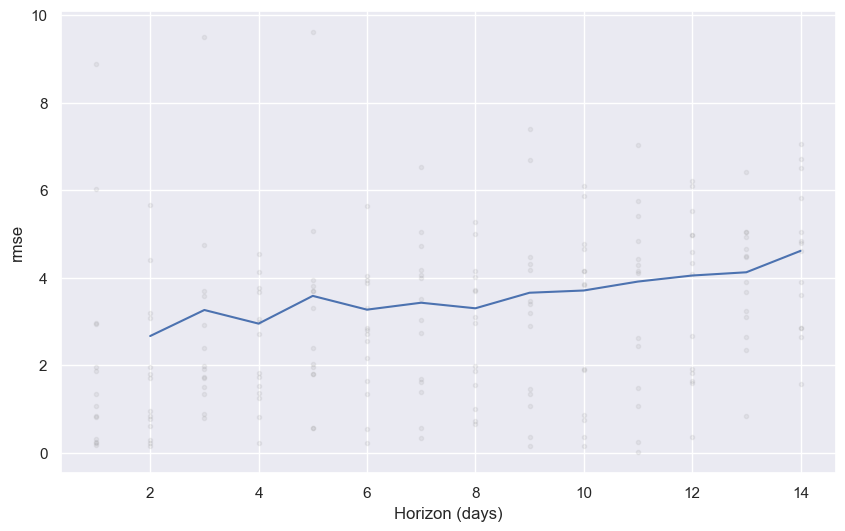

In [71]:
plot_cross_validation_metric(df_cv, 'rmse');

Kita bisa melihat bahwa model kita untuk produk A1 memilik trend meningkat semakin waktu berlalu. Untungnya tidak terjadi explode. Jadi bisa dibilang bahwa model kita sudah reliable. Namun, kita tetap akan melakukan parameter tuning untuk mendapatkan rmse yang terkecil.

In [377]:
future = model_prophet.make_future_dataframe(periods=7)

In [74]:
forecast = model_prophet.predict(future)

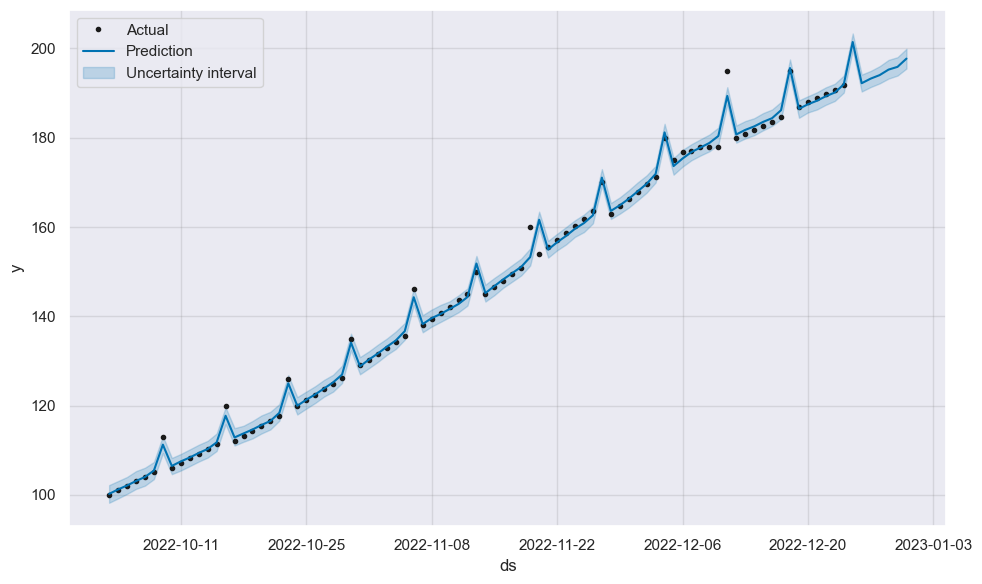

In [75]:
fig = model_prophet.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval']);

Kita bisa melihat bahwa model kita dapat melakukan prediksi dengan baik pada produk A1, namun peningkatan sales yang signifikan tidak dapat terprediksi dengan sangat baik. Model kita juga tidak bisa menangkap fluktuasi pada tanggal kisaran 2022-12-10 - 2022-12-15.

#### Prophet parameter grid

In [76]:
parameter_grid = {'seasonality_mode':['multiplicative', 'additive'],
                 'seasonality_prior_scale':[1,3,5,7],
                 'holidays_prior_scale':[1,3,5,7],
                 'changepoint_prior_scale':[0.01, 0.05, 0.1, 0.8],
                 }
grid = ParameterGrid(parameter_grid)

In [78]:
rmse = []
i = 1
for parameter in grid:
    model_prophet = Prophet(holidays = holidays,
                       seasonality_mode = parameter['seasonality_mode'],
                       seasonality_prior_scale = parameter['seasonality_prior_scale'],
                       holidays_prior_scale = parameter['holidays_prior_scale'],
                       changepoint_prior_scale = parameter['changepoint_prior_scale'])
    model_prophet.fit(a1_sales_train)
    
    df_cv = cross_validation(model_prophet,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')
    
    residual = performance_metrics(df_cv)['rmse'].mean()
    rmse.append(residual)
    
    
    print(f'{i} of {len(list(grid))}')
    i += 1


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


1 of 128


12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing


2 of 128


12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:58 - cmdstanpy - INFO - Chain [1] done processing


3 of 128


12:45:05 - cmdstanpy - INFO - Chain [1] start processing
12:45:05 - cmdstanpy - INFO - Chain [1] done processing


4 of 128


12:45:13 - cmdstanpy - INFO - Chain [1] start processing
12:45:13 - cmdstanpy - INFO - Chain [1] done processing


5 of 128


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


6 of 128


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


7 of 128


12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:36 - cmdstanpy - INFO - Chain [1] done processing


8 of 128


12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing


9 of 128


12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:50 - cmdstanpy - INFO - Chain [1] done processing


10 of 128


12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:56 - cmdstanpy - INFO - Chain [1] done processing


11 of 128


12:46:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing


12 of 128


12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:12 - cmdstanpy - INFO - Chain [1] done processing


13 of 128


12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:20 - cmdstanpy - INFO - Chain [1] done processing


14 of 128


12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


15 of 128


12:46:35 - cmdstanpy - INFO - Chain [1] start processing
12:46:35 - cmdstanpy - INFO - Chain [1] done processing


16 of 128


12:46:43 - cmdstanpy - INFO - Chain [1] start processing
12:46:43 - cmdstanpy - INFO - Chain [1] done processing


17 of 128


12:46:50 - cmdstanpy - INFO - Chain [1] start processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing


18 of 128


12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:46:59 - cmdstanpy - INFO - Chain [1] done processing


19 of 128


12:47:06 - cmdstanpy - INFO - Chain [1] start processing
12:47:06 - cmdstanpy - INFO - Chain [1] done processing


20 of 128


12:47:14 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing


21 of 128


12:47:22 - cmdstanpy - INFO - Chain [1] start processing
12:47:22 - cmdstanpy - INFO - Chain [1] done processing
12:47:30 - cmdstanpy - INFO - Chain [1] start processing


22 of 128


12:47:30 - cmdstanpy - INFO - Chain [1] done processing


23 of 128


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing


24 of 128


12:47:45 - cmdstanpy - INFO - Chain [1] start processing
12:47:46 - cmdstanpy - INFO - Chain [1] done processing
12:47:53 - cmdstanpy - INFO - Chain [1] start processing


25 of 128


12:47:53 - cmdstanpy - INFO - Chain [1] done processing


26 of 128


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


27 of 128


12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


28 of 128


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


29 of 128


12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing


30 of 128


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


31 of 128


12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


32 of 128


12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing


33 of 128


12:48:58 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing


34 of 128


12:49:07 - cmdstanpy - INFO - Chain [1] start processing
12:49:07 - cmdstanpy - INFO - Chain [1] done processing


35 of 128


12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:15 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing


36 of 128


12:49:23 - cmdstanpy - INFO - Chain [1] done processing


37 of 128


12:49:31 - cmdstanpy - INFO - Chain [1] start processing
12:49:31 - cmdstanpy - INFO - Chain [1] done processing


38 of 128


12:49:39 - cmdstanpy - INFO - Chain [1] start processing
12:49:39 - cmdstanpy - INFO - Chain [1] done processing


39 of 128


12:49:47 - cmdstanpy - INFO - Chain [1] start processing
12:49:47 - cmdstanpy - INFO - Chain [1] done processing


40 of 128


12:49:56 - cmdstanpy - INFO - Chain [1] start processing
12:49:56 - cmdstanpy - INFO - Chain [1] done processing


41 of 128


12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing


42 of 128


12:50:12 - cmdstanpy - INFO - Chain [1] start processing
12:50:12 - cmdstanpy - INFO - Chain [1] done processing


43 of 128


12:50:20 - cmdstanpy - INFO - Chain [1] start processing
12:50:21 - cmdstanpy - INFO - Chain [1] done processing


44 of 128


12:50:29 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing


45 of 128


12:50:39 - cmdstanpy - INFO - Chain [1] start processing
12:50:39 - cmdstanpy - INFO - Chain [1] done processing


46 of 128


12:50:48 - cmdstanpy - INFO - Chain [1] start processing
12:50:48 - cmdstanpy - INFO - Chain [1] done processing


47 of 128


12:50:56 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


48 of 128


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


49 of 128


12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


50 of 128


12:51:22 - cmdstanpy - INFO - Chain [1] start processing
12:51:23 - cmdstanpy - INFO - Chain [1] done processing


51 of 128


12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing


52 of 128


12:51:39 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing


53 of 128


12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:50 - cmdstanpy - INFO - Chain [1] done processing


54 of 128


12:51:58 - cmdstanpy - INFO - Chain [1] start processing
12:51:58 - cmdstanpy - INFO - Chain [1] done processing


55 of 128


12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing


56 of 128


12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing


57 of 128


12:52:23 - cmdstanpy - INFO - Chain [1] start processing
12:52:24 - cmdstanpy - INFO - Chain [1] done processing


58 of 128


12:52:31 - cmdstanpy - INFO - Chain [1] start processing
12:52:31 - cmdstanpy - INFO - Chain [1] done processing


59 of 128


12:52:39 - cmdstanpy - INFO - Chain [1] start processing
12:52:39 - cmdstanpy - INFO - Chain [1] done processing


60 of 128


12:52:48 - cmdstanpy - INFO - Chain [1] start processing
12:52:49 - cmdstanpy - INFO - Chain [1] done processing


61 of 128


12:52:58 - cmdstanpy - INFO - Chain [1] start processing
12:52:58 - cmdstanpy - INFO - Chain [1] done processing


62 of 128


12:53:07 - cmdstanpy - INFO - Chain [1] start processing
12:53:07 - cmdstanpy - INFO - Chain [1] done processing


63 of 128


12:53:16 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing


64 of 128


12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:26 - cmdstanpy - INFO - Chain [1] done processing


65 of 128


12:53:35 - cmdstanpy - INFO - Chain [1] start processing
12:53:35 - cmdstanpy - INFO - Chain [1] done processing


66 of 128


12:53:44 - cmdstanpy - INFO - Chain [1] start processing
12:53:44 - cmdstanpy - INFO - Chain [1] done processing


67 of 128


12:53:52 - cmdstanpy - INFO - Chain [1] start processing
12:53:53 - cmdstanpy - INFO - Chain [1] done processing


68 of 128


12:54:01 - cmdstanpy - INFO - Chain [1] start processing
12:54:01 - cmdstanpy - INFO - Chain [1] done processing


69 of 128


12:54:09 - cmdstanpy - INFO - Chain [1] start processing
12:54:09 - cmdstanpy - INFO - Chain [1] done processing


70 of 128


12:54:17 - cmdstanpy - INFO - Chain [1] start processing
12:54:17 - cmdstanpy - INFO - Chain [1] done processing


71 of 128


12:54:25 - cmdstanpy - INFO - Chain [1] start processing
12:54:25 - cmdstanpy - INFO - Chain [1] done processing


72 of 128


12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:34 - cmdstanpy - INFO - Chain [1] done processing


73 of 128


12:54:41 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing


74 of 128


12:54:51 - cmdstanpy - INFO - Chain [1] start processing
12:54:51 - cmdstanpy - INFO - Chain [1] done processing


75 of 128


12:55:00 - cmdstanpy - INFO - Chain [1] start processing
12:55:00 - cmdstanpy - INFO - Chain [1] done processing


76 of 128


12:55:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


77 of 128


12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing


78 of 128


12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing


79 of 128


12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing


80 of 128


12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:53 - cmdstanpy - INFO - Chain [1] done processing


81 of 128


12:56:02 - cmdstanpy - INFO - Chain [1] start processing
12:56:02 - cmdstanpy - INFO - Chain [1] done processing


82 of 128


12:56:11 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


83 of 128


12:56:21 - cmdstanpy - INFO - Chain [1] start processing
12:56:22 - cmdstanpy - INFO - Chain [1] done processing


84 of 128


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


85 of 128


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing


86 of 128


12:56:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:48 - cmdstanpy - INFO - Chain [1] done processing


87 of 128


12:56:57 - cmdstanpy - INFO - Chain [1] start processing
12:56:57 - cmdstanpy - INFO - Chain [1] done processing


88 of 128


12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:07 - cmdstanpy - INFO - Chain [1] done processing


89 of 128


12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing


90 of 128


12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing


91 of 128


12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


92 of 128


12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing


93 of 128


12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing


94 of 128


12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:02 - cmdstanpy - INFO - Chain [1] done processing


95 of 128


12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:11 - cmdstanpy - INFO - Chain [1] done processing


96 of 128


12:58:19 - cmdstanpy - INFO - Chain [1] start processing
12:58:20 - cmdstanpy - INFO - Chain [1] done processing


97 of 128


12:58:28 - cmdstanpy - INFO - Chain [1] start processing
12:58:28 - cmdstanpy - INFO - Chain [1] done processing


98 of 128


12:58:35 - cmdstanpy - INFO - Chain [1] start processing
12:58:36 - cmdstanpy - INFO - Chain [1] done processing


99 of 128


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


100 of 128


12:58:50 - cmdstanpy - INFO - Chain [1] start processing
12:58:50 - cmdstanpy - INFO - Chain [1] done processing


101 of 128


12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:58 - cmdstanpy - INFO - Chain [1] done processing


102 of 128


12:59:06 - cmdstanpy - INFO - Chain [1] start processing
12:59:07 - cmdstanpy - INFO - Chain [1] done processing


103 of 128


12:59:14 - cmdstanpy - INFO - Chain [1] start processing
12:59:15 - cmdstanpy - INFO - Chain [1] done processing


104 of 128


12:59:23 - cmdstanpy - INFO - Chain [1] start processing
12:59:23 - cmdstanpy - INFO - Chain [1] done processing


105 of 128


12:59:32 - cmdstanpy - INFO - Chain [1] start processing
12:59:32 - cmdstanpy - INFO - Chain [1] done processing


106 of 128


12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


107 of 128


12:59:49 - cmdstanpy - INFO - Chain [1] start processing
12:59:49 - cmdstanpy - INFO - Chain [1] done processing


108 of 128


12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:58 - cmdstanpy - INFO - Chain [1] done processing


109 of 128


13:00:06 - cmdstanpy - INFO - Chain [1] start processing
13:00:06 - cmdstanpy - INFO - Chain [1] done processing


110 of 128


13:00:15 - cmdstanpy - INFO - Chain [1] start processing
13:00:15 - cmdstanpy - INFO - Chain [1] done processing


111 of 128


13:00:22 - cmdstanpy - INFO - Chain [1] start processing
13:00:22 - cmdstanpy - INFO - Chain [1] done processing


112 of 128


13:00:30 - cmdstanpy - INFO - Chain [1] start processing
13:00:30 - cmdstanpy - INFO - Chain [1] done processing


113 of 128


13:00:38 - cmdstanpy - INFO - Chain [1] start processing
13:00:38 - cmdstanpy - INFO - Chain [1] done processing


114 of 128


13:00:46 - cmdstanpy - INFO - Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] done processing


115 of 128


13:00:54 - cmdstanpy - INFO - Chain [1] start processing
13:00:54 - cmdstanpy - INFO - Chain [1] done processing


116 of 128


13:01:03 - cmdstanpy - INFO - Chain [1] start processing
13:01:03 - cmdstanpy - INFO - Chain [1] done processing


117 of 128


13:01:12 - cmdstanpy - INFO - Chain [1] start processing
13:01:12 - cmdstanpy - INFO - Chain [1] done processing


118 of 128


13:01:20 - cmdstanpy - INFO - Chain [1] start processing
13:01:20 - cmdstanpy - INFO - Chain [1] done processing


119 of 128


13:01:28 - cmdstanpy - INFO - Chain [1] start processing
13:01:28 - cmdstanpy - INFO - Chain [1] done processing


120 of 128


13:01:36 - cmdstanpy - INFO - Chain [1] start processing
13:01:36 - cmdstanpy - INFO - Chain [1] done processing


121 of 128


13:01:44 - cmdstanpy - INFO - Chain [1] start processing
13:01:45 - cmdstanpy - INFO - Chain [1] done processing


122 of 128


13:01:52 - cmdstanpy - INFO - Chain [1] start processing
13:01:52 - cmdstanpy - INFO - Chain [1] done processing


123 of 128


13:02:00 - cmdstanpy - INFO - Chain [1] start processing
13:02:00 - cmdstanpy - INFO - Chain [1] done processing


124 of 128


13:02:08 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing


125 of 128


13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


126 of 128


13:02:23 - cmdstanpy - INFO - Chain [1] start processing
13:02:23 - cmdstanpy - INFO - Chain [1] done processing


127 of 128


13:02:30 - cmdstanpy - INFO - Chain [1] start processing
13:02:31 - cmdstanpy - INFO - Chain [1] done processing


128 of 128


In [79]:
parameter_tuning_df = pd.DataFrame(grid)
parameter_tuning_df['rmse'] = rmse
parameter_tuning_df.sort_values('rmse')

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
24,0.01,7,multiplicative,1,2.938518
18,0.01,5,multiplicative,5,2.938879
10,0.01,3,multiplicative,5,2.944410
16,0.01,5,multiplicative,1,2.945960
8,0.01,3,multiplicative,1,2.946386
...,...,...,...,...,...
72,0.10,3,multiplicative,1,3.558148
73,0.10,3,multiplicative,3,3.558484
64,0.10,1,multiplicative,1,3.559000
74,0.10,3,multiplicative,5,3.559697


In [80]:
best_hyperparameters = parameter_tuning_df.iloc[parameter_tuning_df.sort_values('rmse').head(1).index,:]
best_hyperparameters

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
24,0.01,7,multiplicative,1,2.938518


In [81]:
changepoint_prior_scale = best_hyperparameters.changepoint_prior_scale.values[0]
changepoint_prior_scale

0.01

In [82]:
holidays_prior_scale = best_hyperparameters.holidays_prior_scale.values[0]
holidays_prior_scale

7

In [83]:
seasonality_mode = best_hyperparameters.seasonality_mode.values[0]
seasonality_mode

'multiplicative'

In [84]:
seasonality_prior_scale = best_hyperparameters.seasonality_prior_scale.values[0]
seasonality_prior_scale

1

#### use the best hyperparameters

In [85]:
model_prophet = Prophet(holidays = holidays,
                       seasonality_mode = seasonality_mode,
                       seasonality_prior_scale = seasonality_prior_scale,
                       holidays_prior_scale = holidays_prior_scale,
                       changepoint_prior_scale = changepoint_prior_scale)
model_prophet.fit(a1_sales_train)
    
df_cv = cross_validation(model_prophet,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')

13:02:38 - cmdstanpy - INFO - Chain [1] start processing
13:02:38 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
residual = performance_metrics(df_cv)['rmse'].mean()
rmse.append(residual)

In [87]:
performance_metrics(df_cv)['rmse'].mean()

2.938517980283976

Dengan melakukan hyperparameter tuning, kita dapat merendahkan nilai rmse dari 3.580424760067483.

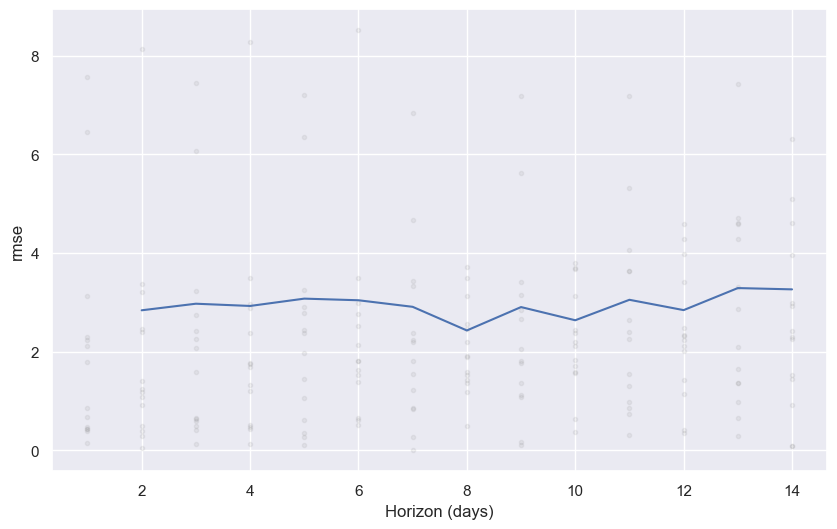

In [89]:
plot_cross_validation_metric(df_cv, 'rmse');

model kita juga terlihat lebih reliable walaupun waktu berlalu.

In [378]:
future = model_prophet.make_future_dataframe(periods=7)

In [92]:
forecast = model_prophet.predict(future)

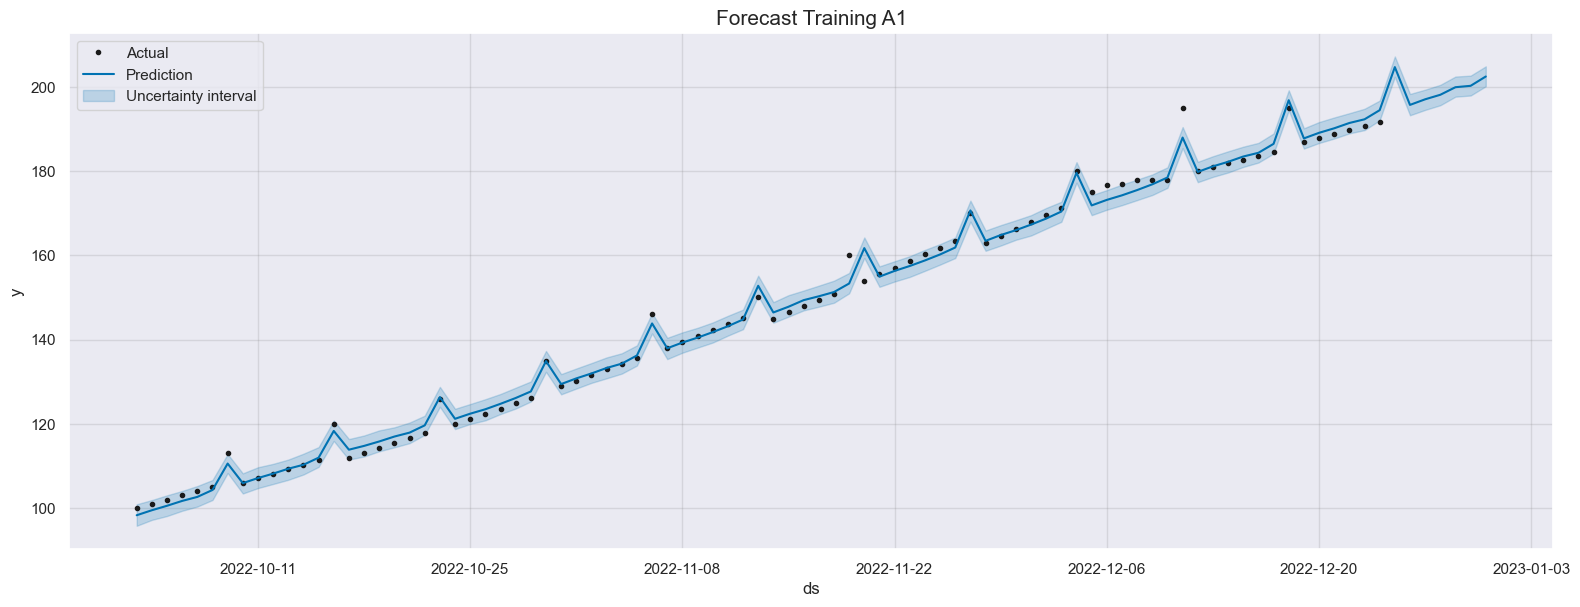

In [422]:
fig = model_prophet.plot(forecast, figsize=(16, 6))
plt.title('Forecast Training A1', size = 15)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.savefig('a1_training_forecast.png', dpi=300);

Disini model kita masih belum bisa menangkap peningkatan sales yang signifkan dan fluktuasi pada bulan desember dengan sangat baik.

#### Evaluation

In [94]:
forecast_test = model_prophet.predict(pd.DataFrame(a1_sales_test.ds))

In [95]:
forecast_test.set_index('ds', inplace=True)

In [96]:
yhat = forecast_test['yhat']
ytrue = a1_sales_test['y']

print(f"RMSE: {np.round(rmse(yhat, ytrue),3)}")

RMSE: 2.125


rmse pada data test kita sangat kecil dan masih di sekitar rmse saat training. Hal ini menunjukkan bahwa model kita good fit dan bagus.

In [97]:
test_predict_df = pd.DataFrame({'yhat':yhat,
             'ytrue':a1_sales_test.set_index('ds')['y']})
test_predict_df

,yhat,ytrue
ds,,
2022-12-25,204.685592,210.000000
2022-12-26,195.712715,196.000000
2022-12-27,197.042738,196.980000
2022-12-28,198.116172,197.964900
2022-12-29,199.913232,198.954724
2022-12-30,200.242339,199.949498
2022-12-31,202.452309,200.949246


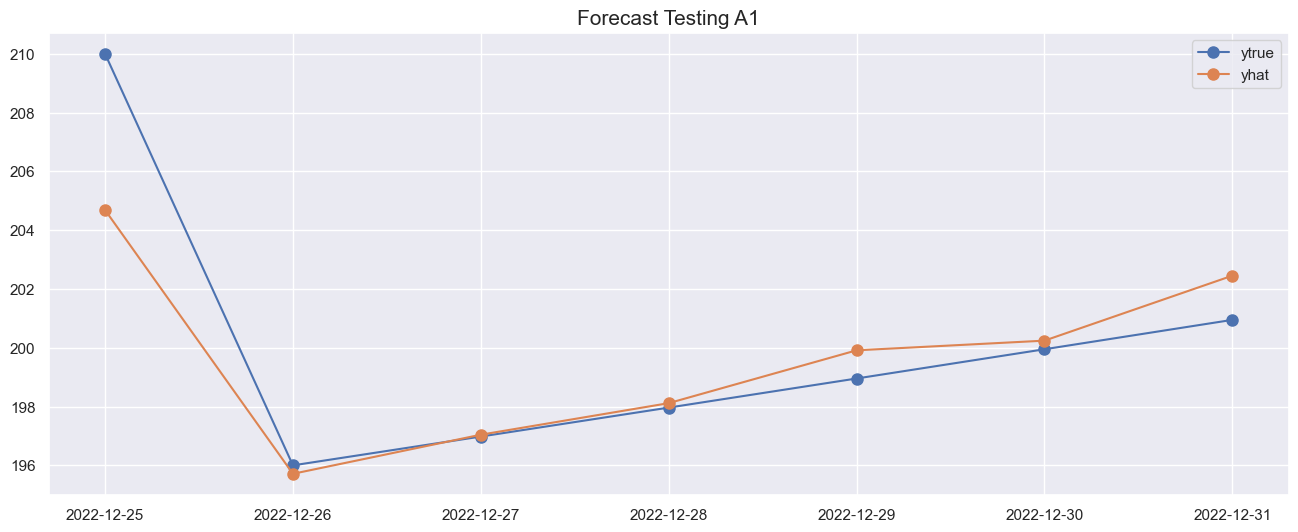

In [414]:
plt.figure(figsize=(16,6))
plt.plot(test_predict_df.ytrue, 'o-', markersize=8, label='ytrue')
plt.plot(test_predict_df.yhat, 'o-', markersize=8, label='yhat')
plt.title('Forecast Testing A1', size = 15)
plt.legend()
plt.savefig('a1_test_forecast.png', dpi=300);

Secara visual kita bisa melihat bahwa model kita dapat melakukan prediksi dengan baik pada data test walaupun model kita masih belum bisa memprediksi sales yang naik signifikan dan fluktuasi dengan sangat baik, tapi hasil prediksinya tidak jauh dari nilai aslinya.

#### Prediksi menggunakan prophet 14 hari ke depan

In [100]:
len(pd.date_range('2023-01-01', '2023-01-14'))

14

In [101]:
predict_df_ds = pd.DataFrame({'ds':pd.date_range('2023-01-01', '2023-01-14')})
predict_df_ds

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
5,2023-01-06
6,2023-01-07
7,2023-01-08
8,2023-01-09
9,2023-01-10


In [102]:
forecast_predict = model_prophet.predict(predict_df_ds)

In [103]:
forecast_predict_df = forecast_predict.set_index('ds')

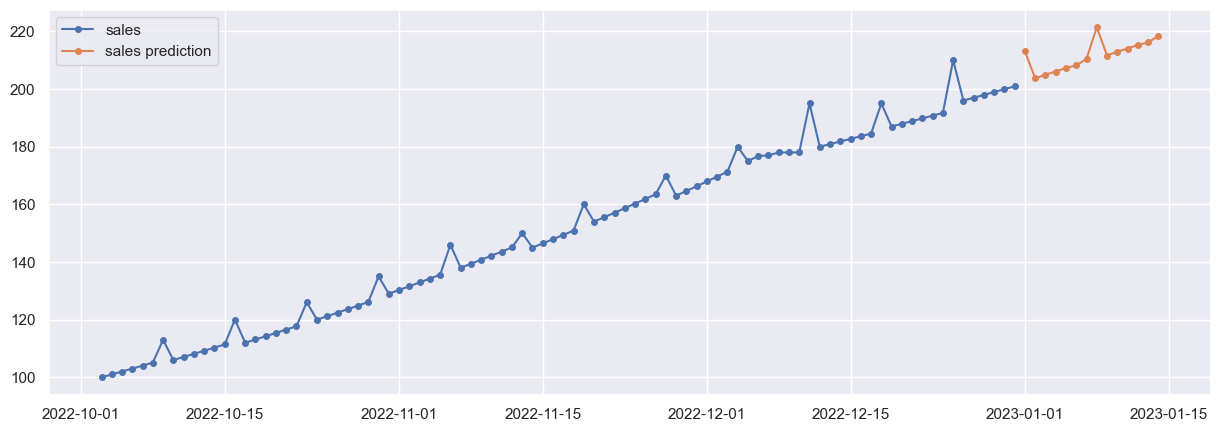

In [394]:
plt.figure(figsize=(15,5))
plt.plot(a1_sales.set_index('ds').y, 'o-', markersize=4, label='sales')
plt.plot(forecast_predict_df.yhat, 'o-', markersize=4, label='sales prediction')
plt.legend()
plt.savefig('a1_prediction_panjang_forecast.png', dpi=300);

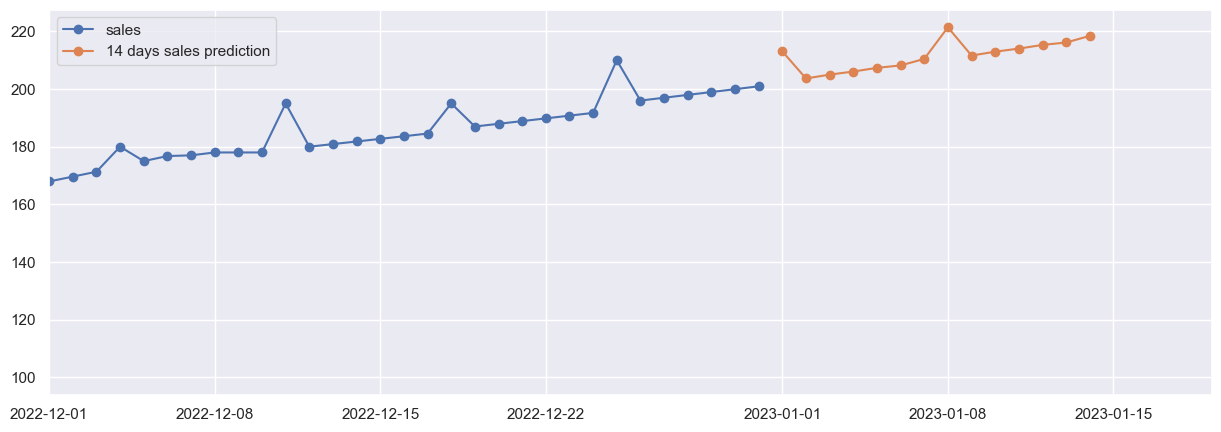

In [395]:
plt.figure(figsize=(15,5))
plt.plot(a1_sales.set_index('ds').y, 'o-', markersize=6, label='sales')
plt.plot(forecast_predict_df.yhat, 'o-', markersize=6, label='14 days sales prediction')
plt.xlim(xmin=datetime.datetime(2022, 12, 1))
plt.legend()
plt.savefig('a1_prediction_pendek_forecast.png', dpi=300);

Kita bisa melihat bahwa sales untuk 2023-01-01 sampai 2023-01-14 diprediksi masih meningkat mengikuti sales yang sudah terjadi.

#### Save model for A1

In [356]:
with open('model_prophet_a1_infer.json', 'w') as file_1:
    file_1.write(model_to_json(model_prophet))

### Produk A2

In [205]:
model_prophet_a2 = Prophet(holidays = holidays,
                       seasonality_mode = 'multiplicative',
                       seasonality_prior_scale = 10,
                       holidays_prior_scale = 10,
                       changepoint_prior_scale = 0.5)

In [207]:
model_prophet_a2.fit(a2_sales_train)

14:08:50 - cmdstanpy - INFO - Chain [1] start processing
14:08:50 - cmdstanpy - INFO - Chain [1] done processing


In [208]:
df_cv_a2 = cross_validation(model_prophet_a2,
                            horizon = '14 days',
                            parallel = 'processes',
                            period = '2 days')

In [209]:
performance_metrics(df_cv_a2)['rmse'].mean()

3.9553880515025788

In [381]:
np.mean(a2_sales_train.y)

1241.6400193780332

nilai rmse sebesar 4 bisa dibilang sangat kecil jika kita bandingkan dengan rata-rata sales produk A2. Hal ini menungjukkan bahwa model kita sudah bagus dalam training.

In [210]:
performance_metrics(df_cv_a2)['mape'].mean() * 100

0.2660328609260851

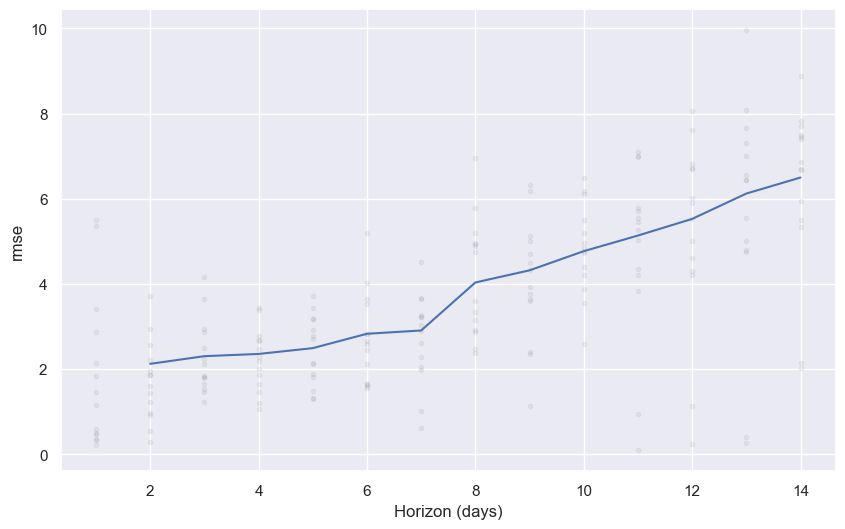

In [212]:
plot_cross_validation_metric(df_cv_a2, 'rmse');

Kita bisa melihat bahwa semakin hari berlalu model kita semakin tidak reliable dalam meprediksi jumlah penjualan produk A2. Namun untungnya tidak ada terjadi explode.

In [214]:
future_a2 = model_prophet_a2.make_future_dataframe(periods=7)

In [215]:
forecast_a2 = model_prophet_a2.predict(future_a2)

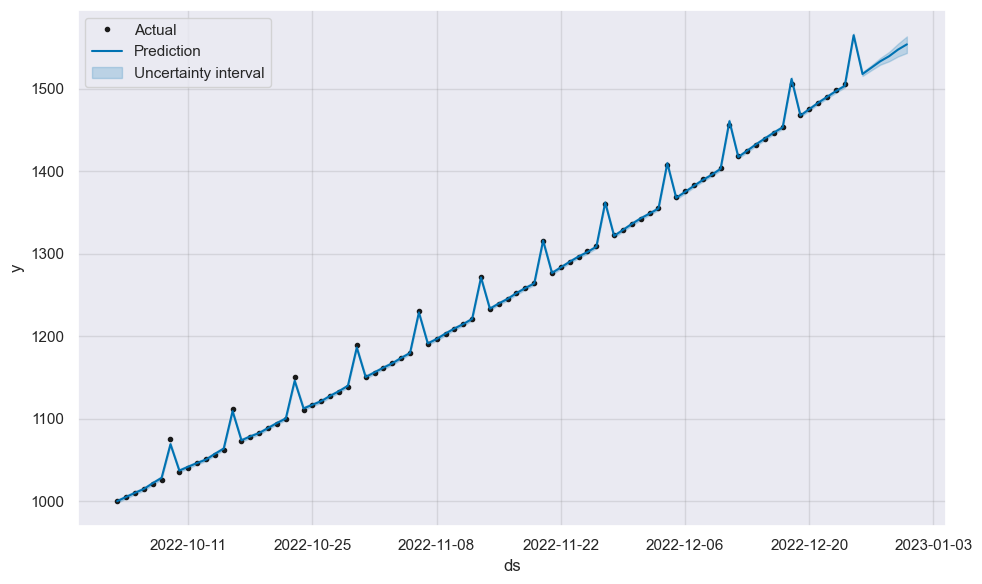

In [216]:
fig = model_prophet_a2.plot(forecast_a2)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval']);

Kita bisa melihat bahwa model kita bisa melakukan prediksi dengan sangat baik pada data training produk A2 termasuk saat harga naik signifikan.

#### Prophet parameter grid

In [217]:
parameter_grid = {'seasonality_mode':['multiplicative', 'additive'],
                 'seasonality_prior_scale':[1,3,5,7],
                 'holidays_prior_scale':[1,3,5,7],
                 'changepoint_prior_scale':[0.01, 0.05, 0.1, 0.8],
                 }
grid = ParameterGrid(parameter_grid)

In [219]:
rmse_a2 = []
i = 1
for parameter in grid:
    model_prophet_a2 = Prophet(holidays = holidays,
                       seasonality_mode = parameter['seasonality_mode'],
                       seasonality_prior_scale = parameter['seasonality_prior_scale'],
                       holidays_prior_scale = parameter['holidays_prior_scale'],
                       changepoint_prior_scale = parameter['changepoint_prior_scale'])
    model_prophet_a2.fit(a2_sales_train)
    
    df_cv_a2 = cross_validation(model_prophet_a2,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')
    
    residual = performance_metrics(df_cv_a2)['rmse'].mean()
    rmse_a2.append(residual)
    
    
    print(f'{i} of {len(list(grid))}')
    i += 1


14:12:19 - cmdstanpy - INFO - Chain [1] start processing
14:12:19 - cmdstanpy - INFO - Chain [1] done processing


1 of 128


14:12:25 - cmdstanpy - INFO - Chain [1] start processing
14:12:25 - cmdstanpy - INFO - Chain [1] done processing


2 of 128


14:12:32 - cmdstanpy - INFO - Chain [1] start processing
14:12:32 - cmdstanpy - INFO - Chain [1] done processing


3 of 128


14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing


4 of 128


14:12:44 - cmdstanpy - INFO - Chain [1] start processing
14:12:44 - cmdstanpy - INFO - Chain [1] done processing


5 of 128


14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing


6 of 128


14:12:59 - cmdstanpy - INFO - Chain [1] start processing
14:12:59 - cmdstanpy - INFO - Chain [1] done processing


7 of 128


14:13:07 - cmdstanpy - INFO - Chain [1] start processing
14:13:07 - cmdstanpy - INFO - Chain [1] done processing


8 of 128


14:13:15 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] done processing


9 of 128


14:13:23 - cmdstanpy - INFO - Chain [1] start processing
14:13:23 - cmdstanpy - INFO - Chain [1] done processing


10 of 128


14:13:30 - cmdstanpy - INFO - Chain [1] start processing
14:13:30 - cmdstanpy - INFO - Chain [1] done processing


11 of 128


14:13:39 - cmdstanpy - INFO - Chain [1] start processing
14:13:39 - cmdstanpy - INFO - Chain [1] done processing


12 of 128


14:13:48 - cmdstanpy - INFO - Chain [1] start processing
14:13:48 - cmdstanpy - INFO - Chain [1] done processing


13 of 128


14:13:56 - cmdstanpy - INFO - Chain [1] start processing
14:13:56 - cmdstanpy - INFO - Chain [1] done processing


14 of 128


14:14:04 - cmdstanpy - INFO - Chain [1] start processing
14:14:04 - cmdstanpy - INFO - Chain [1] done processing


15 of 128


14:14:12 - cmdstanpy - INFO - Chain [1] start processing
14:14:12 - cmdstanpy - INFO - Chain [1] done processing


16 of 128


14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:22 - cmdstanpy - INFO - Chain [1] done processing


17 of 128


14:14:31 - cmdstanpy - INFO - Chain [1] start processing
14:14:31 - cmdstanpy - INFO - Chain [1] done processing


18 of 128


14:14:40 - cmdstanpy - INFO - Chain [1] start processing
14:14:41 - cmdstanpy - INFO - Chain [1] done processing


19 of 128


14:14:49 - cmdstanpy - INFO - Chain [1] start processing
14:14:50 - cmdstanpy - INFO - Chain [1] done processing


20 of 128


14:14:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:59 - cmdstanpy - INFO - Chain [1] done processing


21 of 128


14:15:09 - cmdstanpy - INFO - Chain [1] start processing
14:15:09 - cmdstanpy - INFO - Chain [1] done processing


22 of 128


14:15:18 - cmdstanpy - INFO - Chain [1] start processing
14:15:19 - cmdstanpy - INFO - Chain [1] done processing


23 of 128


14:15:29 - cmdstanpy - INFO - Chain [1] start processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


24 of 128


14:15:38 - cmdstanpy - INFO - Chain [1] start processing
14:15:39 - cmdstanpy - INFO - Chain [1] done processing


25 of 128


14:15:47 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing


26 of 128


14:15:56 - cmdstanpy - INFO - Chain [1] start processing
14:15:56 - cmdstanpy - INFO - Chain [1] done processing


27 of 128


14:16:05 - cmdstanpy - INFO - Chain [1] start processing
14:16:05 - cmdstanpy - INFO - Chain [1] done processing


28 of 128


14:16:13 - cmdstanpy - INFO - Chain [1] start processing
14:16:14 - cmdstanpy - INFO - Chain [1] done processing


29 of 128


14:16:23 - cmdstanpy - INFO - Chain [1] start processing
14:16:23 - cmdstanpy - INFO - Chain [1] done processing


30 of 128


14:16:31 - cmdstanpy - INFO - Chain [1] start processing
14:16:32 - cmdstanpy - INFO - Chain [1] done processing


31 of 128


14:16:41 - cmdstanpy - INFO - Chain [1] start processing
14:16:41 - cmdstanpy - INFO - Chain [1] done processing


32 of 128


14:16:50 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing


33 of 128


14:17:00 - cmdstanpy - INFO - Chain [1] start processing
14:17:00 - cmdstanpy - INFO - Chain [1] done processing


34 of 128


14:17:10 - cmdstanpy - INFO - Chain [1] start processing
14:17:11 - cmdstanpy - INFO - Chain [1] done processing


35 of 128


14:17:20 - cmdstanpy - INFO - Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing


36 of 128


14:17:30 - cmdstanpy - INFO - Chain [1] start processing
14:17:30 - cmdstanpy - INFO - Chain [1] done processing


37 of 128


14:17:39 - cmdstanpy - INFO - Chain [1] start processing
14:17:39 - cmdstanpy - INFO - Chain [1] done processing


38 of 128


14:17:48 - cmdstanpy - INFO - Chain [1] start processing
14:17:49 - cmdstanpy - INFO - Chain [1] done processing


39 of 128


14:17:57 - cmdstanpy - INFO - Chain [1] start processing
14:17:57 - cmdstanpy - INFO - Chain [1] done processing


40 of 128


14:18:07 - cmdstanpy - INFO - Chain [1] start processing
14:18:07 - cmdstanpy - INFO - Chain [1] done processing


41 of 128


14:18:16 - cmdstanpy - INFO - Chain [1] start processing
14:18:17 - cmdstanpy - INFO - Chain [1] done processing


42 of 128


14:18:26 - cmdstanpy - INFO - Chain [1] start processing
14:18:26 - cmdstanpy - INFO - Chain [1] done processing


43 of 128


14:18:35 - cmdstanpy - INFO - Chain [1] start processing
14:18:35 - cmdstanpy - INFO - Chain [1] done processing


44 of 128


14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:44 - cmdstanpy - INFO - Chain [1] done processing


45 of 128


14:18:53 - cmdstanpy - INFO - Chain [1] start processing
14:18:53 - cmdstanpy - INFO - Chain [1] done processing


46 of 128


14:19:01 - cmdstanpy - INFO - Chain [1] start processing
14:19:02 - cmdstanpy - INFO - Chain [1] done processing


47 of 128


14:19:10 - cmdstanpy - INFO - Chain [1] start processing
14:19:10 - cmdstanpy - INFO - Chain [1] done processing


48 of 128


14:19:18 - cmdstanpy - INFO - Chain [1] start processing
14:19:19 - cmdstanpy - INFO - Chain [1] done processing


49 of 128


14:19:27 - cmdstanpy - INFO - Chain [1] start processing
14:19:28 - cmdstanpy - INFO - Chain [1] done processing


50 of 128


14:19:37 - cmdstanpy - INFO - Chain [1] start processing
14:19:37 - cmdstanpy - INFO - Chain [1] done processing


51 of 128


14:19:47 - cmdstanpy - INFO - Chain [1] start processing
14:19:48 - cmdstanpy - INFO - Chain [1] done processing


52 of 128


14:19:57 - cmdstanpy - INFO - Chain [1] start processing
14:19:57 - cmdstanpy - INFO - Chain [1] done processing


53 of 128


14:20:06 - cmdstanpy - INFO - Chain [1] start processing
14:20:06 - cmdstanpy - INFO - Chain [1] done processing


54 of 128


14:20:15 - cmdstanpy - INFO - Chain [1] start processing
14:20:15 - cmdstanpy - INFO - Chain [1] done processing


55 of 128


14:20:24 - cmdstanpy - INFO - Chain [1] start processing
14:20:24 - cmdstanpy - INFO - Chain [1] done processing


56 of 128


14:20:32 - cmdstanpy - INFO - Chain [1] start processing
14:20:32 - cmdstanpy - INFO - Chain [1] done processing


57 of 128


14:20:41 - cmdstanpy - INFO - Chain [1] start processing
14:20:42 - cmdstanpy - INFO - Chain [1] done processing


58 of 128


14:20:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:51 - cmdstanpy - INFO - Chain [1] done processing


59 of 128


14:21:00 - cmdstanpy - INFO - Chain [1] start processing
14:21:00 - cmdstanpy - INFO - Chain [1] done processing


60 of 128


14:21:09 - cmdstanpy - INFO - Chain [1] start processing
14:21:10 - cmdstanpy - INFO - Chain [1] done processing


61 of 128


14:21:19 - cmdstanpy - INFO - Chain [1] start processing
14:21:19 - cmdstanpy - INFO - Chain [1] done processing


62 of 128


14:21:29 - cmdstanpy - INFO - Chain [1] start processing
14:21:29 - cmdstanpy - INFO - Chain [1] done processing


63 of 128


14:21:38 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing


64 of 128


14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:47 - cmdstanpy - INFO - Chain [1] done processing


65 of 128


14:21:56 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing


66 of 128


14:22:06 - cmdstanpy - INFO - Chain [1] start processing
14:22:06 - cmdstanpy - INFO - Chain [1] done processing


67 of 128


14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing


68 of 128


14:22:24 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing


69 of 128


14:22:33 - cmdstanpy - INFO - Chain [1] start processing
14:22:33 - cmdstanpy - INFO - Chain [1] done processing


70 of 128


14:22:42 - cmdstanpy - INFO - Chain [1] start processing
14:22:42 - cmdstanpy - INFO - Chain [1] done processing


71 of 128


14:22:52 - cmdstanpy - INFO - Chain [1] start processing
14:22:52 - cmdstanpy - INFO - Chain [1] done processing


72 of 128


14:22:59 - cmdstanpy - INFO - Chain [1] start processing
14:23:00 - cmdstanpy - INFO - Chain [1] done processing


73 of 128


14:23:08 - cmdstanpy - INFO - Chain [1] start processing
14:23:08 - cmdstanpy - INFO - Chain [1] done processing


74 of 128


14:23:17 - cmdstanpy - INFO - Chain [1] start processing
14:23:17 - cmdstanpy - INFO - Chain [1] done processing


75 of 128


14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:27 - cmdstanpy - INFO - Chain [1] done processing


76 of 128


14:23:35 - cmdstanpy - INFO - Chain [1] start processing
14:23:35 - cmdstanpy - INFO - Chain [1] done processing


77 of 128


14:23:45 - cmdstanpy - INFO - Chain [1] start processing
14:23:46 - cmdstanpy - INFO - Chain [1] done processing


78 of 128


14:23:53 - cmdstanpy - INFO - Chain [1] start processing
14:23:53 - cmdstanpy - INFO - Chain [1] done processing


79 of 128


14:24:02 - cmdstanpy - INFO - Chain [1] start processing
14:24:03 - cmdstanpy - INFO - Chain [1] done processing


80 of 128


14:24:10 - cmdstanpy - INFO - Chain [1] start processing
14:24:10 - cmdstanpy - INFO - Chain [1] done processing


81 of 128


14:24:19 - cmdstanpy - INFO - Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing


82 of 128


14:24:27 - cmdstanpy - INFO - Chain [1] start processing
14:24:27 - cmdstanpy - INFO - Chain [1] done processing


83 of 128


14:24:35 - cmdstanpy - INFO - Chain [1] start processing
14:24:35 - cmdstanpy - INFO - Chain [1] done processing


84 of 128


14:24:43 - cmdstanpy - INFO - Chain [1] start processing
14:24:44 - cmdstanpy - INFO - Chain [1] done processing


85 of 128


14:24:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:52 - cmdstanpy - INFO - Chain [1] done processing


86 of 128


14:25:00 - cmdstanpy - INFO - Chain [1] start processing
14:25:00 - cmdstanpy - INFO - Chain [1] done processing


87 of 128


14:25:09 - cmdstanpy - INFO - Chain [1] start processing
14:25:09 - cmdstanpy - INFO - Chain [1] done processing


88 of 128


14:25:16 - cmdstanpy - INFO - Chain [1] start processing
14:25:17 - cmdstanpy - INFO - Chain [1] done processing


89 of 128


14:25:25 - cmdstanpy - INFO - Chain [1] start processing
14:25:26 - cmdstanpy - INFO - Chain [1] done processing


90 of 128


14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:34 - cmdstanpy - INFO - Chain [1] done processing


91 of 128


14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing


92 of 128


14:25:50 - cmdstanpy - INFO - Chain [1] start processing
14:25:50 - cmdstanpy - INFO - Chain [1] done processing


93 of 128


14:25:58 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing


94 of 128


14:26:06 - cmdstanpy - INFO - Chain [1] start processing
14:26:07 - cmdstanpy - INFO - Chain [1] done processing


95 of 128


14:26:15 - cmdstanpy - INFO - Chain [1] start processing
14:26:15 - cmdstanpy - INFO - Chain [1] done processing


96 of 128


14:26:22 - cmdstanpy - INFO - Chain [1] start processing
14:26:23 - cmdstanpy - INFO - Chain [1] done processing


97 of 128


14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:30 - cmdstanpy - INFO - Chain [1] done processing


98 of 128


14:26:38 - cmdstanpy - INFO - Chain [1] start processing
14:26:38 - cmdstanpy - INFO - Chain [1] done processing


99 of 128


14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing


100 of 128


14:26:54 - cmdstanpy - INFO - Chain [1] start processing
14:26:54 - cmdstanpy - INFO - Chain [1] done processing


101 of 128


14:27:02 - cmdstanpy - INFO - Chain [1] start processing
14:27:02 - cmdstanpy - INFO - Chain [1] done processing


102 of 128


14:27:10 - cmdstanpy - INFO - Chain [1] start processing
14:27:10 - cmdstanpy - INFO - Chain [1] done processing


103 of 128


14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing


104 of 128


14:27:26 - cmdstanpy - INFO - Chain [1] start processing
14:27:26 - cmdstanpy - INFO - Chain [1] done processing


105 of 128


14:27:34 - cmdstanpy - INFO - Chain [1] start processing
14:27:34 - cmdstanpy - INFO - Chain [1] done processing


106 of 128


14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


107 of 128


14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:27:49 - cmdstanpy - INFO - Chain [1] done processing


108 of 128


14:27:58 - cmdstanpy - INFO - Chain [1] start processing
14:27:58 - cmdstanpy - INFO - Chain [1] done processing


109 of 128


14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing


110 of 128


14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing


111 of 128


14:28:25 - cmdstanpy - INFO - Chain [1] start processing
14:28:25 - cmdstanpy - INFO - Chain [1] done processing


112 of 128


14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing


113 of 128


14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing


114 of 128


14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:50 - cmdstanpy - INFO - Chain [1] done processing


115 of 128


14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing


116 of 128


14:29:07 - cmdstanpy - INFO - Chain [1] start processing
14:29:07 - cmdstanpy - INFO - Chain [1] done processing


117 of 128


14:29:15 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing


118 of 128


14:29:26 - cmdstanpy - INFO - Chain [1] start processing
14:29:26 - cmdstanpy - INFO - Chain [1] done processing


119 of 128


14:29:34 - cmdstanpy - INFO - Chain [1] start processing
14:29:34 - cmdstanpy - INFO - Chain [1] done processing


120 of 128


14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing


121 of 128


14:29:52 - cmdstanpy - INFO - Chain [1] start processing
14:29:52 - cmdstanpy - INFO - Chain [1] done processing


122 of 128


14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing


123 of 128


14:30:10 - cmdstanpy - INFO - Chain [1] start processing
14:30:11 - cmdstanpy - INFO - Chain [1] done processing


124 of 128


14:30:20 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing


125 of 128


14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing


126 of 128


14:30:36 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing


127 of 128


14:30:46 - cmdstanpy - INFO - Chain [1] start processing
14:30:46 - cmdstanpy - INFO - Chain [1] done processing


128 of 128


In [220]:
parameter_tuning_df_a2 = pd.DataFrame(grid)
parameter_tuning_df_a2['rmse'] = rmse_a2
parameter_tuning_df_a2.sort_values('rmse')

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
102,0.80,1,additive,5,3.085467
111,0.80,3,additive,7,3.085508
109,0.80,3,additive,3,3.085511
125,0.80,7,additive,3,3.085534
100,0.80,1,additive,1,3.085538
...,...,...,...,...,...
27,0.01,7,multiplicative,7,4.731179
2,0.01,1,multiplicative,5,4.735126
1,0.01,1,multiplicative,3,4.737237
3,0.01,1,multiplicative,7,4.740547


In [221]:
best_hyperparameters_a2 = parameter_tuning_df_a2.iloc[parameter_tuning_df_a2.sort_values('rmse').head(1).index,:]
best_hyperparameters_a2

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
102,0.8,1,additive,5,3.085467


In [222]:
changepoint_prior_scale_a2 = best_hyperparameters_a2.changepoint_prior_scale.values[0]
changepoint_prior_scale_a2

0.8

In [223]:
holidays_prior_scale_a2 = best_hyperparameters_a2.holidays_prior_scale.values[0]
holidays_prior_scale_a2

1

In [224]:
seasonality_mode_a2 = best_hyperparameters_a2.seasonality_mode.values[0]
seasonality_mode_a2

'additive'

In [225]:
seasonality_prior_scale_a2 = best_hyperparameters_a2.seasonality_prior_scale.values[0]
seasonality_prior_scale_a2

5

#### use the best hyperparameters

In [226]:
model_prophet_a2 = Prophet(holidays = holidays,
                       seasonality_mode = seasonality_mode_a2,
                       seasonality_prior_scale = seasonality_prior_scale_a2,
                       holidays_prior_scale = holidays_prior_scale_a2,
                       changepoint_prior_scale = changepoint_prior_scale_a2)
model_prophet_a2.fit(a2_sales_train)
    
df_cv_a2 = cross_validation(model_prophet_a2,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')

14:36:13 - cmdstanpy - INFO - Chain [1] start processing
14:36:13 - cmdstanpy - INFO - Chain [1] done processing


In [227]:
performance_metrics(df_cv_a2)['rmse'].mean()

3.0854665802461225

Setelah menggunakan hyperparamters yang terbaik yang kita dapat, model kita dapat menurunkan nilai rmse jadi 3 dari 3.9553. Hal ini bisa dibilang penurunan yang lumayan signifikan.

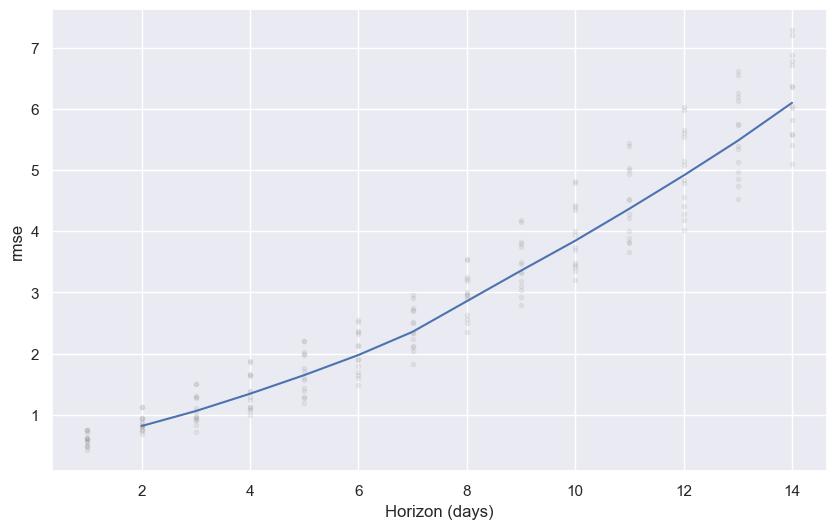

In [229]:
plot_cross_validation_metric(df_cv_a2, 'rmse');

Kita bisa melihat bahwa model kita tidak reliable setelah 4 hari.

In [383]:
future_a2 = model_prophet_a2.make_future_dataframe(periods=7)

In [384]:
forecast_a2 = model_prophet_a2.predict(future_a2)

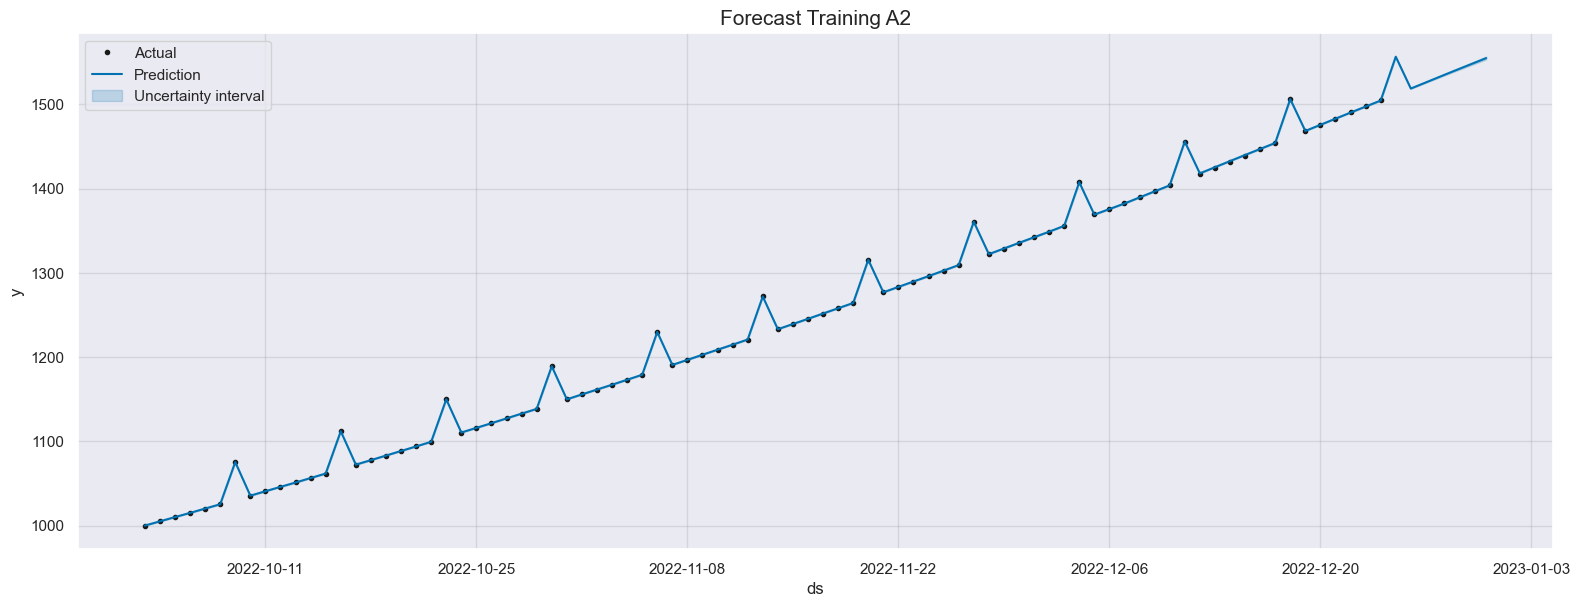

In [421]:
fig = model_prophet_a2.plot(forecast_a2, figsize=(16, 6))
plt.title('Forecast Training A2', size = 15)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.savefig('a2_training_forecast.png', dpi=300);

#### Evaluation

In [239]:
forecast_test_a2 = model_prophet_a2.predict(pd.DataFrame(a2_sales_test.ds))

In [240]:
forecast_test_a2.set_index('ds', inplace=True)

In [242]:
yhat_a2 = forecast_test_a2['yhat']
ytrue_a2 = a2_sales_test['y']

print(f"RMSE: {np.round(rmse(yhat_a2, ytrue_a2),3)}")

RMSE: 2.647


rmse yang didapat pada test set masih disekitar rmse di training set, hal ini menungjukkan bahwa model kita good fit dan bagus.

In [243]:
test_predict_df_a2 = pd.DataFrame({'yhat':yhat_a2,
             'ytrue':a2_sales_test.set_index('ds')['y']})
test_predict_df_a2

,yhat,ytrue
ds,,
2022-12-25,1556.472032,1557.805608
2022-12-26,1518.683257,1520.369636
2022-12-27,1525.957703,1527.971484
2022-12-28,1533.258410,1535.611342
2022-12-29,1540.511881,1543.289398
2022-12-30,1547.641857,1551.005845
2022-12-31,1554.785702,1558.760875


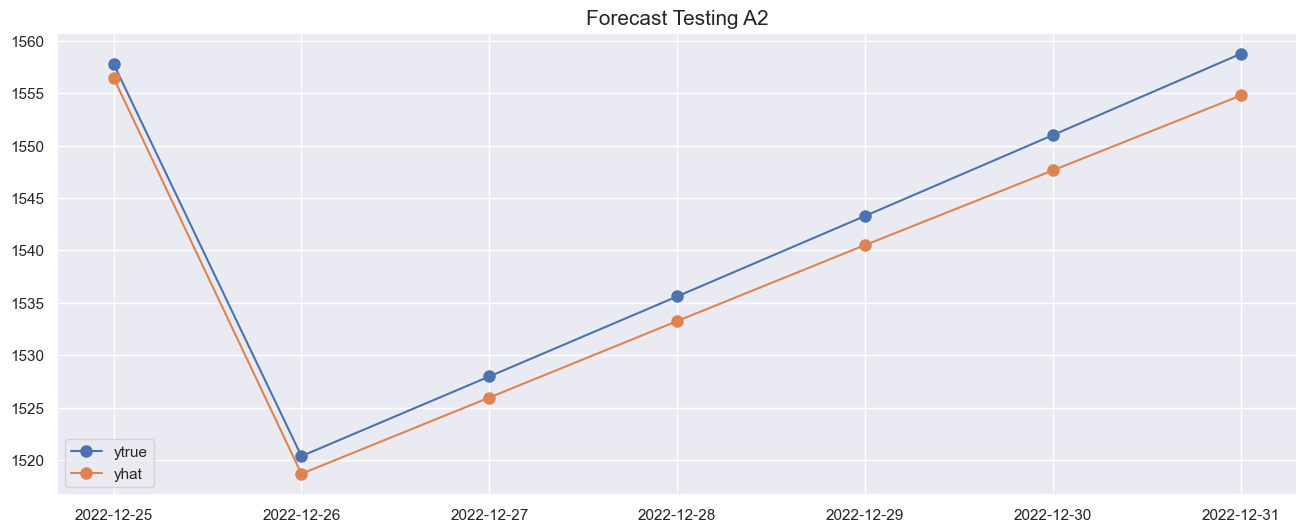

In [415]:
plt.figure(figsize=(16,6))
plt.plot(test_predict_df_a2.ytrue, 'o-', markersize=8, label='ytrue')
plt.plot(test_predict_df_a2.yhat, 'o-', markersize=8, label='yhat')
plt.title('Forecast Testing A2', size = 15)
plt.legend()
plt.savefig('a2_test_forecast.png', dpi=300);

Walaupun prediksi kita tidak precise, tapi hasil prediksi tidak jauh dari nilai asil data test sales produk A2.

#### Prediksi menggunakan prophet 14 hari ke depan

In [245]:
predict_df_ds_a2 = pd.DataFrame({'ds':pd.date_range('2023-01-01', '2023-01-14')})
predict_df_ds_a2

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
5,2023-01-06
6,2023-01-07
7,2023-01-08
8,2023-01-09
9,2023-01-10


In [246]:
forecast_predict_a2 = model_prophet_a2.predict(predict_df_ds_a2)

In [247]:
forecast_predict_df_a2 = forecast_predict_a2.set_index('ds')

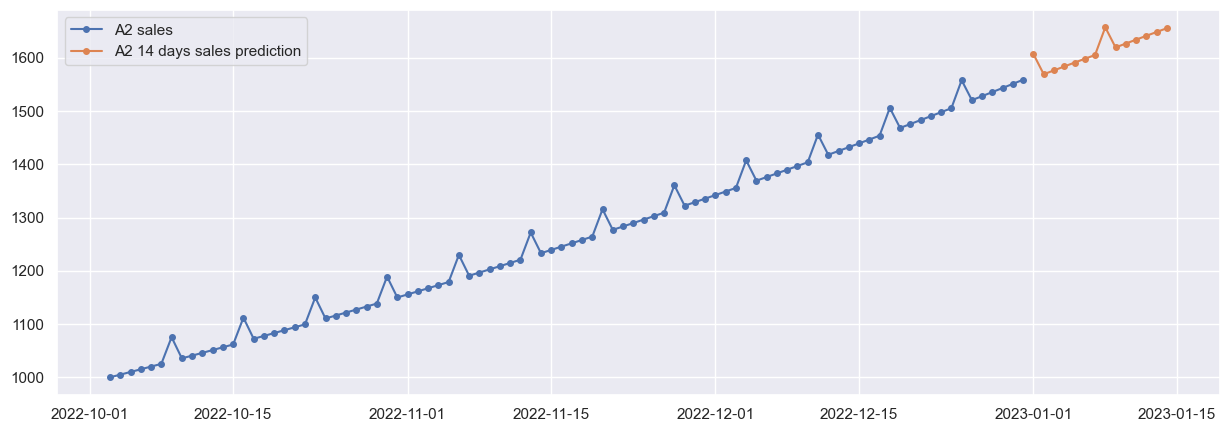

In [398]:
plt.figure(figsize=(15,5))
plt.plot(a2_sales.set_index('ds').y, 'o-', markersize=4, label='A2 sales')
plt.plot(forecast_predict_df_a2.yhat, 'o-', markersize=4, label='A2 14 days sales prediction')
plt.legend()
plt.savefig('a2_prediction_panjang_forecast.png', dpi=300);

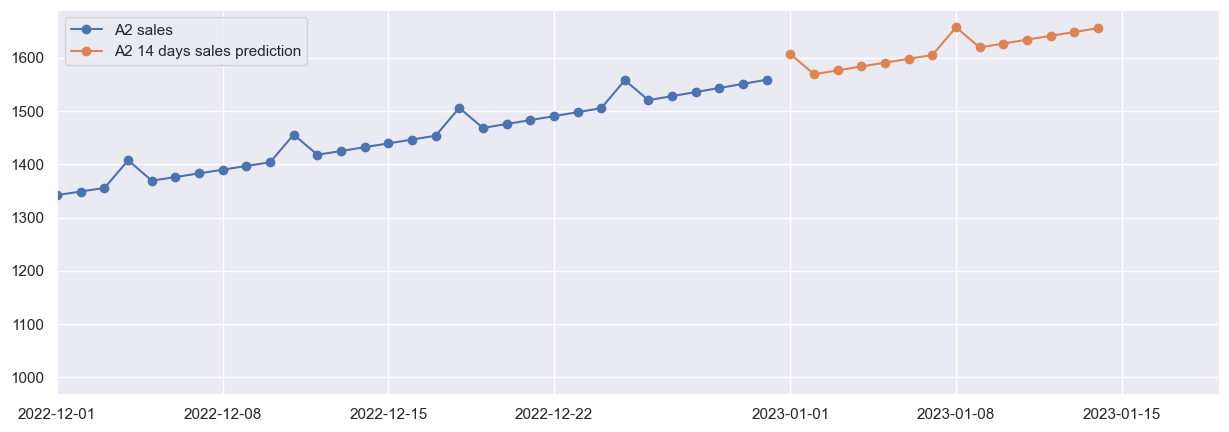

In [399]:
plt.figure(figsize=(15,5))
plt.plot(a2_sales.set_index('ds').y, 'o-', markersize=6, label='A2 sales')
plt.plot(forecast_predict_df_a2.yhat, 'o-', markersize=6, label='A2 14 days sales prediction')
plt.xlim(xmin=datetime.datetime(2022, 12, 1))
plt.legend()
plt.savefig('a2_prediction_pendek_forecast.png', dpi=300);

Kita bisa melihat bahwa sales pada tanggal 1 Januari 2023 sampai 14 Januari 2023 masih mengalami peningkatan.

#### Save model for A2

In [250]:
with open('model_prophet_a2_infer.json', 'w') as file_1:
    file_1.write(model_to_json(model_prophet_a2))

### Produk B1

In [254]:
model_prophet_b1 = Prophet(holidays = holidays,
                       seasonality_mode = 'multiplicative',
                       seasonality_prior_scale = 10,
                       holidays_prior_scale = 10,
                       changepoint_prior_scale = 0.5)

In [255]:
model_prophet_b1.fit(b1_sales_train)

14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing


In [256]:
df_cv_b1 = cross_validation(model_prophet_b1,
                            horizon = '14 days',
                            parallel = 'processes',
                            period = '2 days')

In [257]:
performance_metrics(df_cv_b1)['rmse'].mean()

48.908514460205204

In [386]:
np.mean(b1_sales_train.y)

1063.012048192771

rmse 48 tidak bisa dibilang besar jika kita bandingkan dengan rata-rata sales produk B1 sebesar 1063. Hal ini masih bisa menunjukkan bahwa model kita punya performance yang tidak buruk atau cukup bagus.

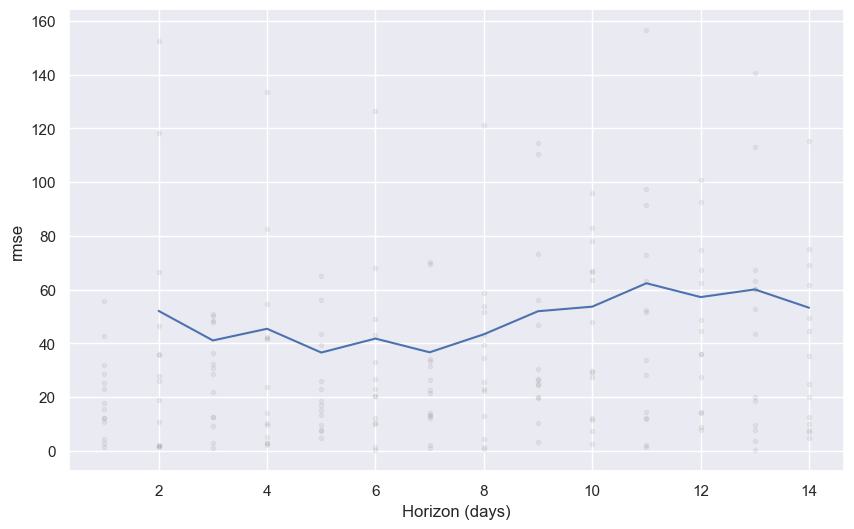

In [259]:
plot_cross_validation_metric(df_cv_b1, 'rmse');

Model kita masih bisa dibilang tetap reliable walaupun banyak hari telah berlalu.

In [261]:
future_b1 = model_prophet_b1.make_future_dataframe(periods=7)

In [262]:
forecast_b1 = model_prophet_b1.predict(future_b1)

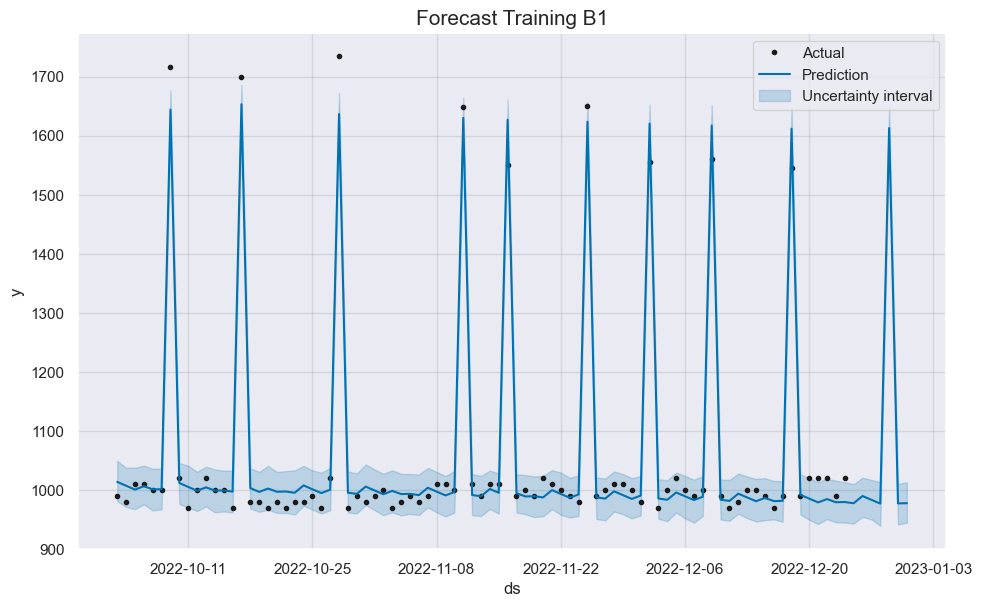

In [411]:
fig = model_prophet_b1.plot(forecast_b1)
plt.title('Forecast Training B1', size = 15)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval']);

Model kita tidak dapat melakukan prediksi secara precise disebabkan oleh sales produk B1 yang sering mengalami fluktuasi walaupun tidak signifikan.

#### Prophet parameter grid

In [264]:
parameter_grid = {'seasonality_mode':['multiplicative', 'additive'],
                 'seasonality_prior_scale':[1,3,5,7],
                 'holidays_prior_scale':[1,3,5,7],
                 'changepoint_prior_scale':[0.01, 0.05, 0.1, 0.8],
                 }
grid = ParameterGrid(parameter_grid)

In [266]:
rmse_b1 = []
i = 1
for parameter in grid:
    model_prophet_b1 = Prophet(holidays = holidays,
                       seasonality_mode = parameter['seasonality_mode'],
                       seasonality_prior_scale = parameter['seasonality_prior_scale'],
                       holidays_prior_scale = parameter['holidays_prior_scale'],
                       changepoint_prior_scale = parameter['changepoint_prior_scale'])
    model_prophet_b1.fit(b1_sales_train)
    
    df_cv_b1 = cross_validation(model_prophet_b1,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')
    
    residual = performance_metrics(df_cv_b1)['rmse'].mean()
    rmse_b1.append(residual)
    
    
    print(f'{i} of {len(list(grid))}')
    i += 1


14:43:04 - cmdstanpy - INFO - Chain [1] start processing
14:43:04 - cmdstanpy - INFO - Chain [1] done processing


1 of 128


14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing


2 of 128


14:43:15 - cmdstanpy - INFO - Chain [1] start processing
14:43:16 - cmdstanpy - INFO - Chain [1] done processing


3 of 128


14:43:21 - cmdstanpy - INFO - Chain [1] start processing
14:43:21 - cmdstanpy - INFO - Chain [1] done processing


4 of 128


14:43:27 - cmdstanpy - INFO - Chain [1] start processing
14:43:27 - cmdstanpy - INFO - Chain [1] done processing


5 of 128


14:43:33 - cmdstanpy - INFO - Chain [1] start processing
14:43:33 - cmdstanpy - INFO - Chain [1] done processing


6 of 128


14:43:40 - cmdstanpy - INFO - Chain [1] start processing
14:43:40 - cmdstanpy - INFO - Chain [1] done processing


7 of 128


14:43:46 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing


8 of 128


14:43:53 - cmdstanpy - INFO - Chain [1] start processing
14:43:54 - cmdstanpy - INFO - Chain [1] done processing


9 of 128


14:44:00 - cmdstanpy - INFO - Chain [1] start processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing


10 of 128


14:44:07 - cmdstanpy - INFO - Chain [1] start processing
14:44:07 - cmdstanpy - INFO - Chain [1] done processing


11 of 128


14:44:14 - cmdstanpy - INFO - Chain [1] start processing
14:44:15 - cmdstanpy - INFO - Chain [1] done processing


12 of 128


14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:23 - cmdstanpy - INFO - Chain [1] done processing


13 of 128


14:44:30 - cmdstanpy - INFO - Chain [1] start processing
14:44:31 - cmdstanpy - INFO - Chain [1] done processing


14 of 128


14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing


15 of 128


14:44:46 - cmdstanpy - INFO - Chain [1] start processing
14:44:46 - cmdstanpy - INFO - Chain [1] done processing


16 of 128


14:44:54 - cmdstanpy - INFO - Chain [1] start processing
14:44:54 - cmdstanpy - INFO - Chain [1] done processing


17 of 128


14:45:02 - cmdstanpy - INFO - Chain [1] start processing
14:45:02 - cmdstanpy - INFO - Chain [1] done processing


18 of 128


14:45:09 - cmdstanpy - INFO - Chain [1] start processing
14:45:10 - cmdstanpy - INFO - Chain [1] done processing


19 of 128


14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:18 - cmdstanpy - INFO - Chain [1] done processing


20 of 128


14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing


21 of 128


14:45:33 - cmdstanpy - INFO - Chain [1] start processing
14:45:33 - cmdstanpy - INFO - Chain [1] done processing


22 of 128


14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] done processing


23 of 128


14:45:48 - cmdstanpy - INFO - Chain [1] start processing
14:45:49 - cmdstanpy - INFO - Chain [1] done processing


24 of 128


14:45:56 - cmdstanpy - INFO - Chain [1] start processing
14:45:56 - cmdstanpy - INFO - Chain [1] done processing


25 of 128


14:46:04 - cmdstanpy - INFO - Chain [1] start processing
14:46:04 - cmdstanpy - INFO - Chain [1] done processing


26 of 128


14:46:12 - cmdstanpy - INFO - Chain [1] start processing
14:46:12 - cmdstanpy - INFO - Chain [1] done processing


27 of 128


14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:20 - cmdstanpy - INFO - Chain [1] done processing


28 of 128


14:46:27 - cmdstanpy - INFO - Chain [1] start processing
14:46:28 - cmdstanpy - INFO - Chain [1] done processing


29 of 128


14:46:35 - cmdstanpy - INFO - Chain [1] start processing
14:46:35 - cmdstanpy - INFO - Chain [1] done processing


30 of 128


14:46:43 - cmdstanpy - INFO - Chain [1] start processing
14:46:43 - cmdstanpy - INFO - Chain [1] done processing


31 of 128


14:46:51 - cmdstanpy - INFO - Chain [1] start processing
14:46:51 - cmdstanpy - INFO - Chain [1] done processing


32 of 128


14:46:59 - cmdstanpy - INFO - Chain [1] start processing
14:46:59 - cmdstanpy - INFO - Chain [1] done processing


33 of 128


14:47:07 - cmdstanpy - INFO - Chain [1] start processing
14:47:07 - cmdstanpy - INFO - Chain [1] done processing


34 of 128


14:47:15 - cmdstanpy - INFO - Chain [1] start processing
14:47:15 - cmdstanpy - INFO - Chain [1] done processing


35 of 128


14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] done processing


36 of 128


14:47:31 - cmdstanpy - INFO - Chain [1] start processing
14:47:31 - cmdstanpy - INFO - Chain [1] done processing


37 of 128


14:47:38 - cmdstanpy - INFO - Chain [1] start processing
14:47:39 - cmdstanpy - INFO - Chain [1] done processing


38 of 128


14:47:47 - cmdstanpy - INFO - Chain [1] start processing
14:47:47 - cmdstanpy - INFO - Chain [1] done processing


39 of 128


14:47:55 - cmdstanpy - INFO - Chain [1] start processing
14:47:55 - cmdstanpy - INFO - Chain [1] done processing


40 of 128


14:48:03 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing


41 of 128


14:48:11 - cmdstanpy - INFO - Chain [1] start processing
14:48:11 - cmdstanpy - INFO - Chain [1] done processing


42 of 128


14:48:19 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


43 of 128


14:48:26 - cmdstanpy - INFO - Chain [1] start processing
14:48:27 - cmdstanpy - INFO - Chain [1] done processing


44 of 128


14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:35 - cmdstanpy - INFO - Chain [1] done processing


45 of 128


14:48:43 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing


46 of 128


14:48:51 - cmdstanpy - INFO - Chain [1] start processing
14:48:51 - cmdstanpy - INFO - Chain [1] done processing


47 of 128


14:48:59 - cmdstanpy - INFO - Chain [1] start processing
14:48:59 - cmdstanpy - INFO - Chain [1] done processing


48 of 128


14:49:07 - cmdstanpy - INFO - Chain [1] start processing
14:49:08 - cmdstanpy - INFO - Chain [1] done processing


49 of 128


14:49:15 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] done processing


50 of 128


14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:23 - cmdstanpy - INFO - Chain [1] done processing


51 of 128


14:49:31 - cmdstanpy - INFO - Chain [1] start processing
14:49:31 - cmdstanpy - INFO - Chain [1] done processing


52 of 128


14:49:39 - cmdstanpy - INFO - Chain [1] start processing
14:49:39 - cmdstanpy - INFO - Chain [1] done processing


53 of 128


14:49:47 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing


54 of 128


14:49:56 - cmdstanpy - INFO - Chain [1] start processing
14:49:56 - cmdstanpy - INFO - Chain [1] done processing


55 of 128


14:50:05 - cmdstanpy - INFO - Chain [1] start processing
14:50:05 - cmdstanpy - INFO - Chain [1] done processing


56 of 128


14:50:14 - cmdstanpy - INFO - Chain [1] start processing
14:50:14 - cmdstanpy - INFO - Chain [1] done processing


57 of 128


14:50:22 - cmdstanpy - INFO - Chain [1] start processing
14:50:23 - cmdstanpy - INFO - Chain [1] done processing


58 of 128


14:50:32 - cmdstanpy - INFO - Chain [1] start processing
14:50:32 - cmdstanpy - INFO - Chain [1] done processing


59 of 128


14:50:41 - cmdstanpy - INFO - Chain [1] start processing
14:50:41 - cmdstanpy - INFO - Chain [1] done processing


60 of 128


14:50:49 - cmdstanpy - INFO - Chain [1] start processing
14:50:50 - cmdstanpy - INFO - Chain [1] done processing


61 of 128


14:50:58 - cmdstanpy - INFO - Chain [1] start processing
14:50:59 - cmdstanpy - INFO - Chain [1] done processing


62 of 128


14:51:06 - cmdstanpy - INFO - Chain [1] start processing
14:51:07 - cmdstanpy - INFO - Chain [1] done processing


63 of 128


14:51:16 - cmdstanpy - INFO - Chain [1] start processing
14:51:17 - cmdstanpy - INFO - Chain [1] done processing


64 of 128


14:51:27 - cmdstanpy - INFO - Chain [1] start processing
14:51:27 - cmdstanpy - INFO - Chain [1] done processing


65 of 128


14:51:36 - cmdstanpy - INFO - Chain [1] start processing
14:51:36 - cmdstanpy - INFO - Chain [1] done processing


66 of 128


14:51:47 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing


67 of 128


14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:57 - cmdstanpy - INFO - Chain [1] done processing


68 of 128


14:52:07 - cmdstanpy - INFO - Chain [1] start processing
14:52:08 - cmdstanpy - INFO - Chain [1] done processing


69 of 128


14:52:17 - cmdstanpy - INFO - Chain [1] start processing
14:52:17 - cmdstanpy - INFO - Chain [1] done processing


70 of 128


14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:27 - cmdstanpy - INFO - Chain [1] done processing


71 of 128


14:52:37 - cmdstanpy - INFO - Chain [1] start processing
14:52:38 - cmdstanpy - INFO - Chain [1] done processing


72 of 128


14:52:49 - cmdstanpy - INFO - Chain [1] start processing
14:52:50 - cmdstanpy - INFO - Chain [1] done processing


73 of 128


14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing


74 of 128


14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing


75 of 128


14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing


76 of 128


14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing


77 of 128


14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


78 of 128


14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing


79 of 128


14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing


80 of 128


14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing


81 of 128


14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


82 of 128


14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing


83 of 128


14:54:25 - cmdstanpy - INFO - Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing


84 of 128


14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing


85 of 128


14:54:42 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:51 - cmdstanpy - INFO - Chain [1] start processing


86 of 128


14:54:51 - cmdstanpy - INFO - Chain [1] done processing


87 of 128


14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing


88 of 128


14:55:09 - cmdstanpy - INFO - Chain [1] start processing
14:55:09 - cmdstanpy - INFO - Chain [1] done processing


89 of 128


14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing


90 of 128


14:55:26 - cmdstanpy - INFO - Chain [1] start processing
14:55:27 - cmdstanpy - INFO - Chain [1] done processing


91 of 128


14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


92 of 128


14:55:44 - cmdstanpy - INFO - Chain [1] start processing
14:55:44 - cmdstanpy - INFO - Chain [1] done processing


93 of 128


14:55:52 - cmdstanpy - INFO - Chain [1] start processing
14:55:53 - cmdstanpy - INFO - Chain [1] done processing


94 of 128


14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing


95 of 128


14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing


96 of 128


14:56:24 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing


97 of 128


14:56:33 - cmdstanpy - INFO - Chain [1] start processing
14:56:34 - cmdstanpy - INFO - Chain [1] done processing


98 of 128


14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing


99 of 128


14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing


100 of 128


14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing


101 of 128


14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing


102 of 128


14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing


103 of 128


14:57:32 - cmdstanpy - INFO - Chain [1] start processing
14:57:32 - cmdstanpy - INFO - Chain [1] done processing


104 of 128


14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing


105 of 128


14:57:49 - cmdstanpy - INFO - Chain [1] start processing
14:57:50 - cmdstanpy - INFO - Chain [1] done processing


106 of 128


14:57:59 - cmdstanpy - INFO - Chain [1] start processing
14:57:59 - cmdstanpy - INFO - Chain [1] done processing


107 of 128


14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:09 - cmdstanpy - INFO - Chain [1] done processing


108 of 128


14:58:18 - cmdstanpy - INFO - Chain [1] start processing
14:58:19 - cmdstanpy - INFO - Chain [1] done processing


109 of 128


14:58:28 - cmdstanpy - INFO - Chain [1] start processing
14:58:28 - cmdstanpy - INFO - Chain [1] done processing


110 of 128


14:58:37 - cmdstanpy - INFO - Chain [1] start processing
14:58:37 - cmdstanpy - INFO - Chain [1] done processing


111 of 128


14:58:47 - cmdstanpy - INFO - Chain [1] start processing
14:58:47 - cmdstanpy - INFO - Chain [1] done processing


112 of 128


14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing


113 of 128


14:59:05 - cmdstanpy - INFO - Chain [1] start processing
14:59:05 - cmdstanpy - INFO - Chain [1] done processing


114 of 128


14:59:15 - cmdstanpy - INFO - Chain [1] start processing
14:59:15 - cmdstanpy - INFO - Chain [1] done processing


115 of 128


14:59:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:26 - cmdstanpy - INFO - Chain [1] done processing


116 of 128


14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] done processing


117 of 128


14:59:43 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] done processing


118 of 128


14:59:52 - cmdstanpy - INFO - Chain [1] start processing
14:59:53 - cmdstanpy - INFO - Chain [1] done processing


119 of 128


15:00:01 - cmdstanpy - INFO - Chain [1] start processing
15:00:02 - cmdstanpy - INFO - Chain [1] done processing


120 of 128


15:00:10 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing


121 of 128


15:00:18 - cmdstanpy - INFO - Chain [1] start processing
15:00:19 - cmdstanpy - INFO - Chain [1] done processing


122 of 128


15:00:27 - cmdstanpy - INFO - Chain [1] start processing
15:00:27 - cmdstanpy - INFO - Chain [1] done processing


123 of 128


15:00:35 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing


124 of 128


15:00:44 - cmdstanpy - INFO - Chain [1] start processing
15:00:44 - cmdstanpy - INFO - Chain [1] done processing


125 of 128


15:00:52 - cmdstanpy - INFO - Chain [1] start processing
15:00:53 - cmdstanpy - INFO - Chain [1] done processing


126 of 128


15:01:02 - cmdstanpy - INFO - Chain [1] start processing
15:01:02 - cmdstanpy - INFO - Chain [1] done processing


127 of 128


15:01:13 - cmdstanpy - INFO - Chain [1] start processing
15:01:13 - cmdstanpy - INFO - Chain [1] done processing


128 of 128


In [267]:
parameter_tuning_df_b1 = pd.DataFrame(grid)
parameter_tuning_df_b1['rmse'] = rmse_b1
parameter_tuning_df_b1.sort_values('rmse')

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
19,0.01,5,multiplicative,7,35.752844
24,0.01,7,multiplicative,1,35.791084
2,0.01,1,multiplicative,5,35.801801
18,0.01,5,multiplicative,5,35.802969
11,0.01,3,multiplicative,7,35.829301
...,...,...,...,...,...
115,0.80,5,multiplicative,7,48.544416
122,0.80,7,multiplicative,5,48.548371
120,0.80,7,multiplicative,1,48.550989
121,0.80,7,multiplicative,3,48.552311


In [268]:
best_hyperparameters_b1 = parameter_tuning_df_b1.iloc[parameter_tuning_df_b1.sort_values('rmse').head(1).index,:]
best_hyperparameters_b1

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
19,0.01,5,multiplicative,7,35.752844


In [269]:
changepoint_prior_scale_b1 = best_hyperparameters_b1.changepoint_prior_scale.values[0]
changepoint_prior_scale_b1

0.01

In [270]:
holidays_prior_scale_b1 = best_hyperparameters_b1.holidays_prior_scale.values[0]
holidays_prior_scale_b1

5

In [271]:
seasonality_mode_b1 = best_hyperparameters_b1.seasonality_mode.values[0]
seasonality_mode_b1

'multiplicative'

In [272]:
seasonality_prior_scale_b1 = best_hyperparameters_b1.seasonality_prior_scale.values[0]
seasonality_prior_scale_b1

7

#### use hyperparameters

In [273]:
model_prophet_b1 = Prophet(holidays = holidays,
                       seasonality_mode = seasonality_mode_b1,
                       seasonality_prior_scale = seasonality_prior_scale_b1,
                       holidays_prior_scale = holidays_prior_scale_b1,
                       changepoint_prior_scale = changepoint_prior_scale_b1)
model_prophet_b1.fit(b1_sales_train)
    
df_cv_b1 = cross_validation(model_prophet_b1,
                        horizon = '14 days',
                        parallel = 'processes',
                        period = '2 days')

15:03:34 - cmdstanpy - INFO - Chain [1] start processing
15:03:34 - cmdstanpy - INFO - Chain [1] done processing


In [274]:
performance_metrics(df_cv_b1)['rmse'].mean()

35.752844067698135

Setelah melakukan hyperparemeter tuning, model kita dapat menurunkan error dari 48.9085 ke 35.75.

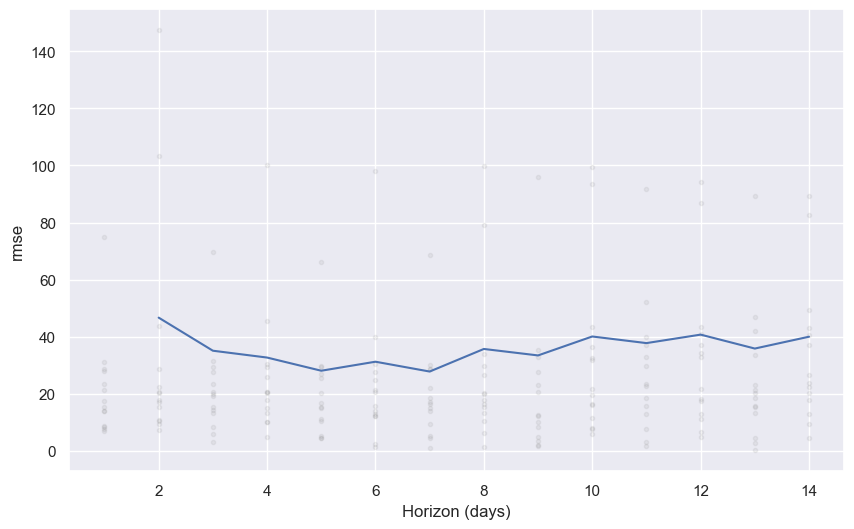

In [276]:
plot_cross_validation_metric(df_cv_b1, 'rmse');

In [387]:
future_b1 = model_prophet_b1.make_future_dataframe(periods=7)

In [279]:
forecast_b1 = model_prophet_b1.predict(future_b1)

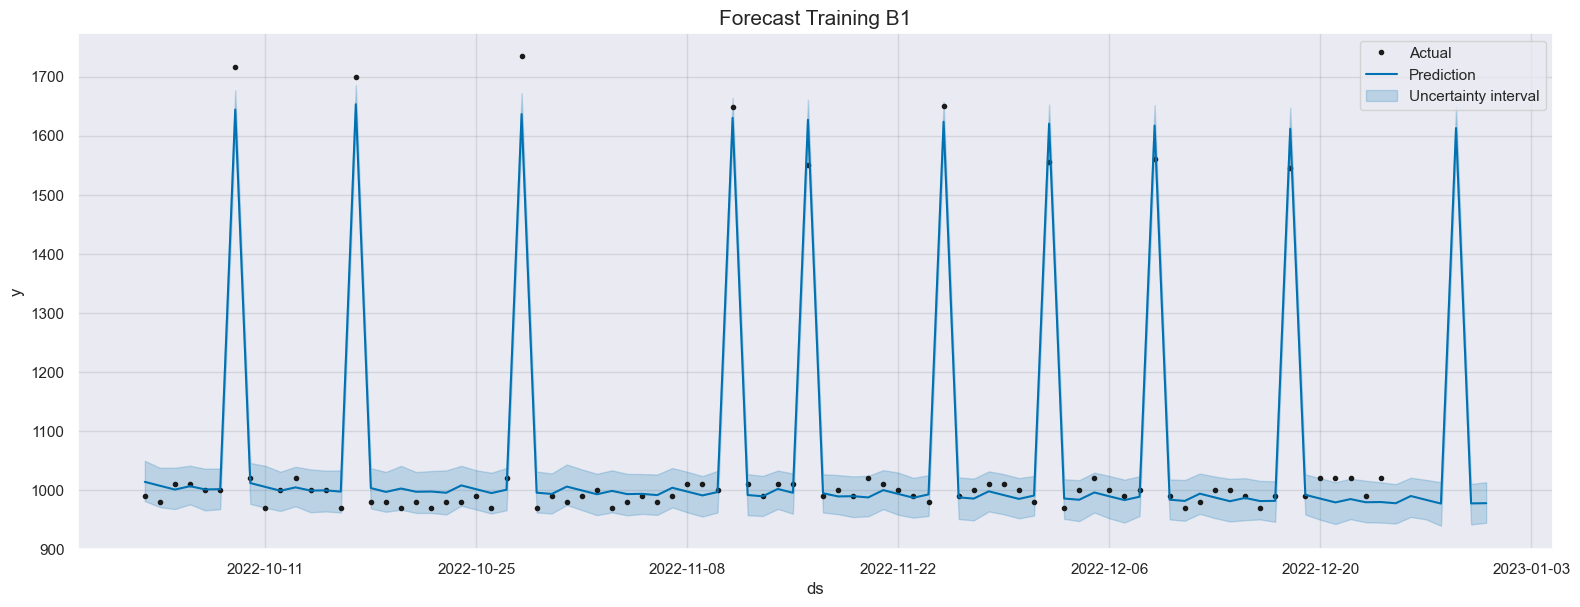

In [420]:
fig = model_prophet_b1.plot(forecast_b1, figsize=(16, 6))
plt.title('Forecast Training B1', size = 15)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.savefig('b1_training_forecast.png', dpi=300);

Hasil prediksi untuk data training paling tidak sama performance dengan model sebelum dituning.

#### Evaluation

In [281]:
forecast_test_b1 = model_prophet_b1.predict(pd.DataFrame(b1_sales_test.ds))

In [282]:
forecast_test_b1.set_index('ds', inplace=True)

In [283]:
yhat_b1 = forecast_test_b1['yhat']
ytrue_b1 = b1_sales_test['y']

print(f"RMSE: {np.round(rmse(yhat_b1, ytrue_b1),3)}")

RMSE: 64.061


rmse dari data test kita tidak jauh dengan rmse saat training. Maka dari itu model kita masih bisa dibilang good fit.

In [284]:
test_predict_df_b1 = pd.DataFrame({'yhat':yhat_b1,
             'ytrue':b1_sales_test.set_index('ds')['y']})
test_predict_df_b1

,yhat,ytrue
ds,,
2022-12-25,977.836328,980.0
2022-12-26,990.068491,980.0
2022-12-27,983.636504,1010.0
2022-12-28,977.304346,1020.0
2022-12-29,1612.812828,1455.0
2022-12-30,977.560886,1010.0
2022-12-31,977.924879,990.0


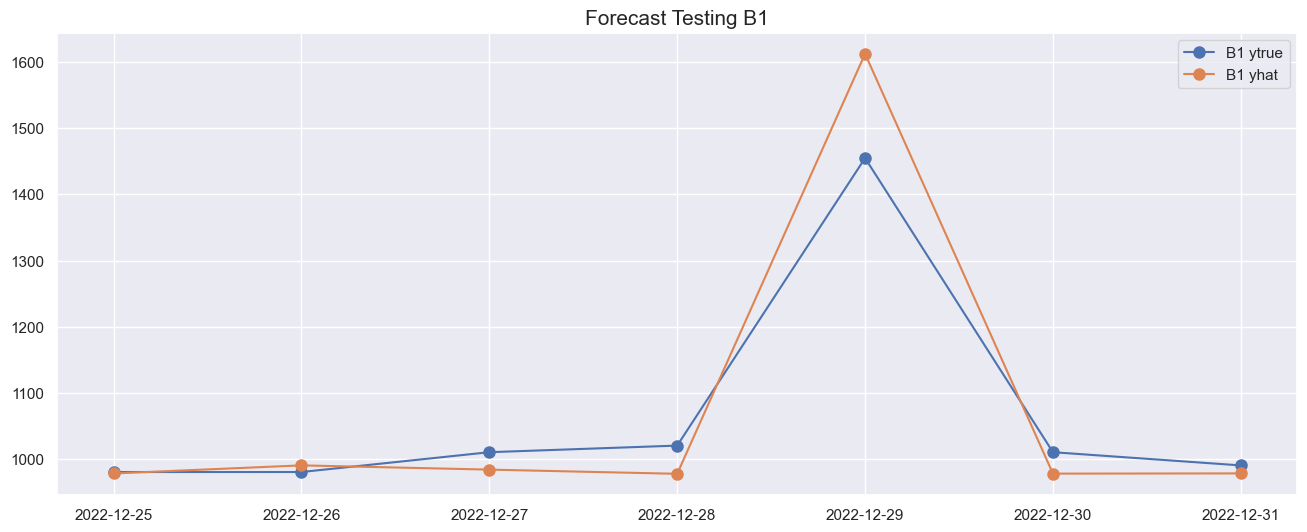

In [416]:
plt.figure(figsize=(16,6))
plt.plot(test_predict_df_b1.ytrue, 'o-', markersize=8, label='B1 ytrue')
plt.plot(test_predict_df_b1.yhat, 'o-', markersize=8, label='B1 yhat')
plt.title('Forecast Testing B1', size = 15)
plt.legend()
plt.savefig('b1_test_forecast.png', dpi=300);

Secara general, model kita dapat melakukan prediksi pada data test dengan baik, hanya saja tidak precise.

#### Prediksi menggunakan prophet 14 hari ke depan

In [286]:
predict_df_ds_b1 = pd.DataFrame({'ds':pd.date_range('2023-01-01', '2023-01-14')})
predict_df_ds_b1

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
5,2023-01-06
6,2023-01-07
7,2023-01-08
8,2023-01-09
9,2023-01-10


In [287]:
forecast_predict_b1 = model_prophet_b1.predict(predict_df_ds_b1)

In [288]:
forecast_predict_df_b1 = forecast_predict_b1.set_index('ds')

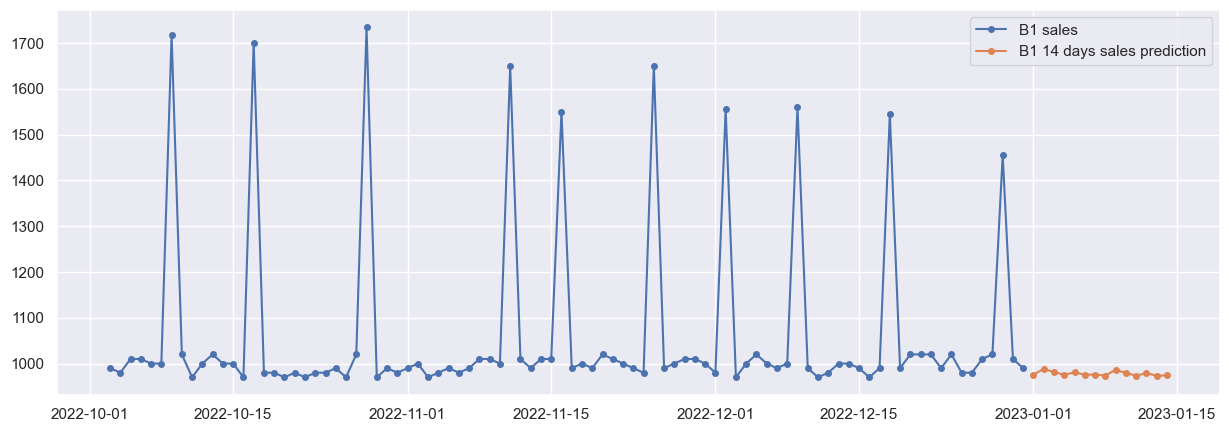

In [402]:
plt.figure(figsize=(15,5))
plt.plot(b1_sales.set_index('ds').y, 'o-', markersize=4, label='B1 sales')
plt.plot(forecast_predict_df_b1.yhat, 'o-', markersize=4, label='B1 14 days sales prediction')
plt.legend()
plt.savefig('b1_prediction_panjang_forecast.png', dpi=300);

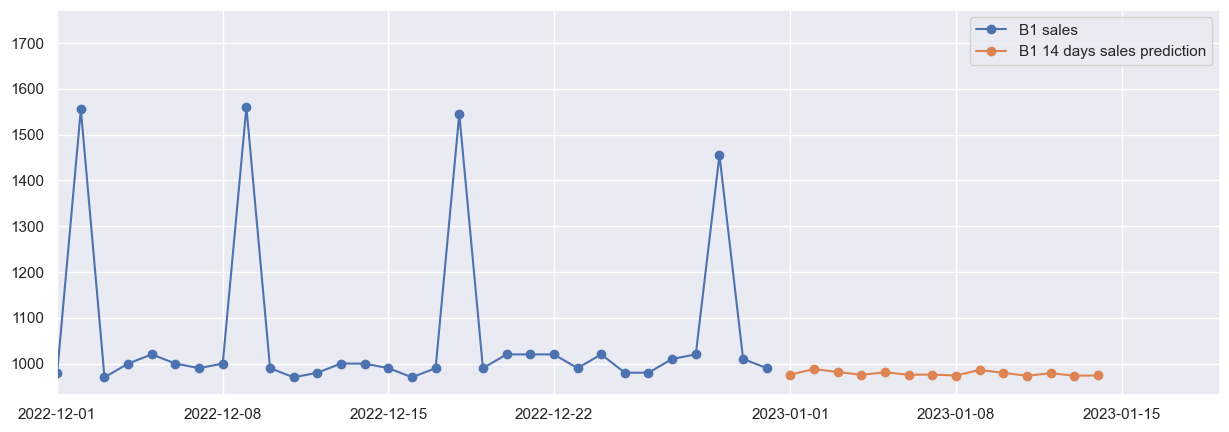

In [403]:
plt.figure(figsize=(15,5))
plt.plot(b1_sales.set_index('ds').y, 'o-', markersize=6, label='B1 sales')
plt.plot(forecast_predict_df_b1.yhat, 'o-', markersize=6, label='B1 14 days sales prediction')
plt.xlim(xmin=datetime.datetime(2022, 12, 1))
plt.legend()
plt.savefig('b1_prediction_pendek_forecast.png', dpi=300);

Hasil prediksi selama 14 hari dari 1 Januari sampai 14 Januari 2023 tidak mengalami peningkatan maupun penurunan.

#### Save model for B1

In [291]:
with open('model_prophet_b1_infer.json', 'w') as file_1:
    file_1.write(model_to_json(model_prophet_b1))

### Produk B2

In [294]:
model_prophet_b2 = Prophet(holidays = holidays,
                       seasonality_mode = 'multiplicative',
                       seasonality_prior_scale = 10,
                       holidays_prior_scale = 10,
                       changepoint_prior_scale = 0.5)

In [295]:
model_prophet_b2.fit(b2_sales_train)

15:07:41 - cmdstanpy - INFO - Chain [1] start processing
15:07:50 - cmdstanpy - INFO - Chain [1] done processing


In [298]:
df_cv_b2 = cross_validation(model_prophet_b2,
                            horizon = '4 days',
                            parallel = 'processes',
                            period = '2 days')

In [299]:
performance_metrics(df_cv_b2)['rmse'].mean()

2474.0370830380093

In [389]:
np.mean(b2_sales_train.y)

2112.832616626743

rmse kita sangat besar. Maka dari itu kita harus melakukan hyperparameter tuning.

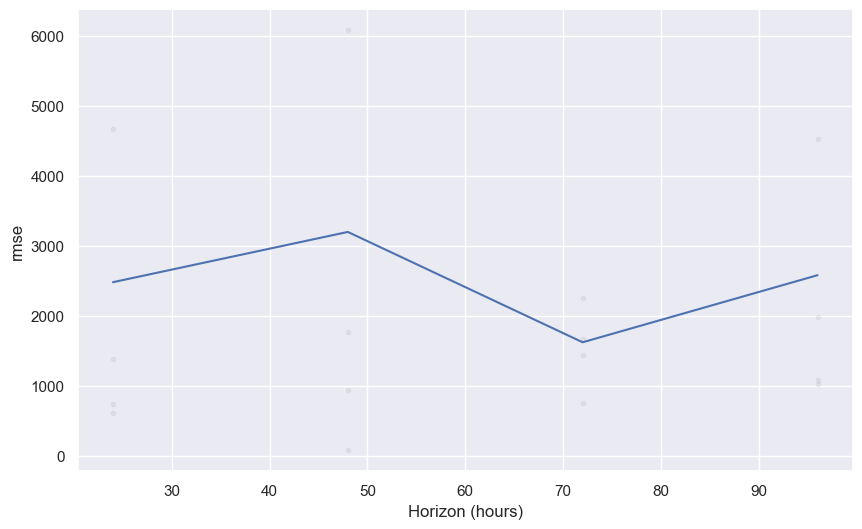

In [301]:
plot_cross_validation_metric(df_cv_b2, 'rmse');

In [303]:
future_b2 = model_prophet_b2.make_future_dataframe(periods=7)

In [304]:
forecast_b2 = model_prophet_b2.predict(future_b2)

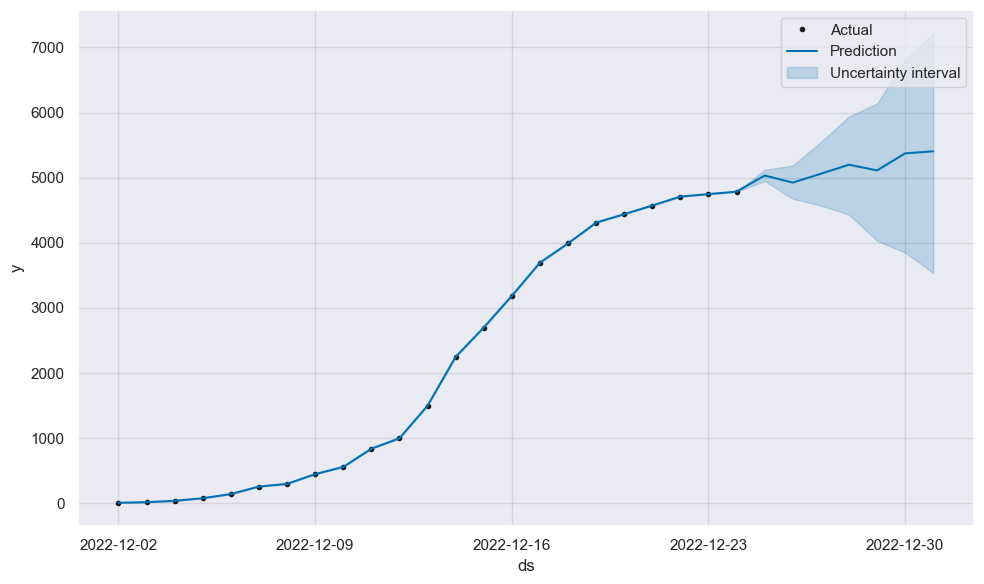

In [305]:
fig = model_prophet_b2.plot(forecast_b2)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval']);

#### Prophet parameter grid

In [306]:
parameter_grid = {'seasonality_mode':['multiplicative', 'additive'],
                 'seasonality_prior_scale':[1,3,5,7],
                 'holidays_prior_scale':[1,3,5,7],
                 'changepoint_prior_scale':[0.01, 0.05, 0.1, 0.8],
                 }
grid = ParameterGrid(parameter_grid)

In [308]:
rmse_b2 = []
i = 1
for parameter in grid:
    model_prophet_b2 = Prophet(holidays = holidays,
                       seasonality_mode = parameter['seasonality_mode'],
                       seasonality_prior_scale = parameter['seasonality_prior_scale'],
                       holidays_prior_scale = parameter['holidays_prior_scale'],
                       changepoint_prior_scale = parameter['changepoint_prior_scale'])
    model_prophet_b2.fit(b2_sales_train)
    
    df_cv_b2 = cross_validation(model_prophet_b2,
                        horizon = '4 days',
                        parallel = 'processes',
                        period = '2 days')
    
    residual = performance_metrics(df_cv_b2)['rmse'].mean()
    rmse_b2.append(residual)
    
    
    print(f'{i} of {len(list(grid))}')
    i += 1


15:11:11 - cmdstanpy - INFO - Chain [1] start processing
15:11:11 - cmdstanpy - INFO - Chain [1] done processing


1 of 128


15:11:14 - cmdstanpy - INFO - Chain [1] start processing
15:11:14 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing


2 of 128


15:11:18 - cmdstanpy - INFO - Chain [1] done processing


3 of 128


15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:21 - cmdstanpy - INFO - Chain [1] done processing


4 of 128


15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing
15:11:27 - cmdstanpy - INFO - Chain [1] start processing


5 of 128


15:11:27 - cmdstanpy - INFO - Chain [1] done processing


6 of 128


15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing


7 of 128


15:11:33 - cmdstanpy - INFO - Chain [1] done processing
15:11:35 - cmdstanpy - INFO - Chain [1] start processing


8 of 128


15:11:36 - cmdstanpy - INFO - Chain [1] done processing
15:11:39 - cmdstanpy - INFO - Chain [1] start processing


9 of 128


15:11:39 - cmdstanpy - INFO - Chain [1] done processing
15:11:42 - cmdstanpy - INFO - Chain [1] start processing


10 of 128


15:11:42 - cmdstanpy - INFO - Chain [1] done processing


11 of 128


15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1] done processing


12 of 128


15:11:49 - cmdstanpy - INFO - Chain [1] start processing
15:11:50 - cmdstanpy - INFO - Chain [1] done processing
15:11:53 - cmdstanpy - INFO - Chain [1] start processing


13 of 128


15:11:53 - cmdstanpy - INFO - Chain [1] done processing
15:11:57 - cmdstanpy - INFO - Chain [1] start processing


14 of 128


15:11:57 - cmdstanpy - INFO - Chain [1] done processing
15:12:01 - cmdstanpy - INFO - Chain [1] start processing


15 of 128


15:12:01 - cmdstanpy - INFO - Chain [1] done processing


16 of 128


15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing


17 of 128


15:12:08 - cmdstanpy - INFO - Chain [1] start processing
15:12:08 - cmdstanpy - INFO - Chain [1] done processing
15:12:12 - cmdstanpy - INFO - Chain [1] start processing


18 of 128


15:12:12 - cmdstanpy - INFO - Chain [1] done processing
15:12:16 - cmdstanpy - INFO - Chain [1] start processing


19 of 128


15:12:16 - cmdstanpy - INFO - Chain [1] done processing


20 of 128


15:12:20 - cmdstanpy - INFO - Chain [1] start processing
15:12:21 - cmdstanpy - INFO - Chain [1] done processing


21 of 128


15:12:24 - cmdstanpy - INFO - Chain [1] start processing
15:12:25 - cmdstanpy - INFO - Chain [1] done processing


22 of 128


15:12:29 - cmdstanpy - INFO - Chain [1] start processing
15:12:29 - cmdstanpy - INFO - Chain [1] done processing


23 of 128


15:12:33 - cmdstanpy - INFO - Chain [1] start processing
15:12:33 - cmdstanpy - INFO - Chain [1] done processing


24 of 128


15:12:37 - cmdstanpy - INFO - Chain [1] start processing
15:12:37 - cmdstanpy - INFO - Chain [1] done processing


25 of 128


15:12:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:41 - cmdstanpy - INFO - Chain [1] done processing


26 of 128


15:12:45 - cmdstanpy - INFO - Chain [1] start processing
15:12:45 - cmdstanpy - INFO - Chain [1] done processing


27 of 128


15:12:49 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing


28 of 128


15:12:52 - cmdstanpy - INFO - Chain [1] start processing
15:12:52 - cmdstanpy - INFO - Chain [1] done processing


29 of 128


15:12:56 - cmdstanpy - INFO - Chain [1] start processing
15:12:56 - cmdstanpy - INFO - Chain [1] done processing
15:13:00 - cmdstanpy - INFO - Chain [1] start processing


30 of 128


15:13:00 - cmdstanpy - INFO - Chain [1] done processing
15:13:04 - cmdstanpy - INFO - Chain [1] start processing


31 of 128


15:13:04 - cmdstanpy - INFO - Chain [1] done processing
15:13:08 - cmdstanpy - INFO - Chain [1] start processing


32 of 128


15:13:08 - cmdstanpy - INFO - Chain [1] done processing


33 of 128


15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:12 - cmdstanpy - INFO - Chain [1] done processing


34 of 128


15:13:16 - cmdstanpy - INFO - Chain [1] start processing
15:13:16 - cmdstanpy - INFO - Chain [1] done processing
15:13:20 - cmdstanpy - INFO - Chain [1] start processing


35 of 128


15:13:20 - cmdstanpy - INFO - Chain [1] done processing


36 of 128


15:13:24 - cmdstanpy - INFO - Chain [1] start processing
15:13:24 - cmdstanpy - INFO - Chain [1] done processing
15:13:28 - cmdstanpy - INFO - Chain [1] start processing


37 of 128


15:13:28 - cmdstanpy - INFO - Chain [1] done processing


38 of 128


15:13:32 - cmdstanpy - INFO - Chain [1] start processing
15:13:32 - cmdstanpy - INFO - Chain [1] done processing


39 of 128


15:13:36 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing
15:13:40 - cmdstanpy - INFO - Chain [1] start processing


40 of 128


15:13:40 - cmdstanpy - INFO - Chain [1] done processing


41 of 128


15:13:44 - cmdstanpy - INFO - Chain [1] start processing
15:13:44 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing


42 of 128


15:13:48 - cmdstanpy - INFO - Chain [1] done processing


43 of 128


15:13:52 - cmdstanpy - INFO - Chain [1] start processing
15:13:52 - cmdstanpy - INFO - Chain [1] done processing


44 of 128


15:13:56 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1] done processing


45 of 128


15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing


46 of 128


15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:06 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing


47 of 128


15:14:10 - cmdstanpy - INFO - Chain [1] done processing


48 of 128


15:14:14 - cmdstanpy - INFO - Chain [1] start processing
15:14:14 - cmdstanpy - INFO - Chain [1] done processing


49 of 128


15:14:18 - cmdstanpy - INFO - Chain [1] start processing
15:14:18 - cmdstanpy - INFO - Chain [1] done processing
15:14:21 - cmdstanpy - INFO - Chain [1] start processing


50 of 128


15:14:22 - cmdstanpy - INFO - Chain [1] done processing


51 of 128


15:14:25 - cmdstanpy - INFO - Chain [1] start processing
15:14:26 - cmdstanpy - INFO - Chain [1] done processing


52 of 128


15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing


53 of 128


15:14:35 - cmdstanpy - INFO - Chain [1] start processing
15:14:35 - cmdstanpy - INFO - Chain [1] done processing


54 of 128


15:14:39 - cmdstanpy - INFO - Chain [1] start processing
15:14:39 - cmdstanpy - INFO - Chain [1] done processing


55 of 128


15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing


56 of 128


15:14:49 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing


57 of 128


15:14:54 - cmdstanpy - INFO - Chain [1] start processing
15:14:54 - cmdstanpy - INFO - Chain [1] done processing


58 of 128


15:14:58 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing


59 of 128


15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing


60 of 128


15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing


61 of 128


15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing


62 of 128


15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing


63 of 128


15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing


64 of 128


15:15:25 - cmdstanpy - INFO - Chain [1] start processing
15:15:25 - cmdstanpy - INFO - Chain [1] done processing
15:15:45 - cmdstanpy - INFO - Chain [1] start processing


65 of 128


15:15:45 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing


66 of 128


15:16:05 - cmdstanpy - INFO - Chain [1] done processing


67 of 128


15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing


68 of 128


15:16:47 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing


69 of 128


15:16:51 - cmdstanpy - INFO - Chain [1] start processing
15:16:51 - cmdstanpy - INFO - Chain [1] done processing


70 of 128


15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing


71 of 128


15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing


72 of 128


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing
15:17:24 - cmdstanpy - INFO - Chain [1] start processing


73 of 128


15:17:24 - cmdstanpy - INFO - Chain [1] done processing


74 of 128


15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:42 - cmdstanpy - INFO - Chain [1] done processing


75 of 128


15:18:04 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1] done processing


76 of 128


15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


77 of 128


15:18:29 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing


78 of 128


15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing


79 of 128


15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:39 - cmdstanpy - INFO - Chain [1] done processing


80 of 128


15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:44 - cmdstanpy - INFO - Chain [1] done processing


81 of 128


15:19:01 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:20 - cmdstanpy - INFO - Chain [1] start processing


82 of 128


15:19:21 - cmdstanpy - INFO - Chain [1] done processing
15:19:36 - cmdstanpy - INFO - Chain [1] start processing


83 of 128


15:19:36 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing


84 of 128


15:19:52 - cmdstanpy - INFO - Chain [1] done processing


85 of 128


15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing


86 of 128


15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing


87 of 128


15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing


88 of 128


15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing


89 of 128


15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing


90 of 128


15:20:46 - cmdstanpy - INFO - Chain [1] done processing
15:21:04 - cmdstanpy - INFO - Chain [1] start processing


91 of 128


15:21:05 - cmdstanpy - INFO - Chain [1] done processing


92 of 128


15:21:22 - cmdstanpy - INFO - Chain [1] start processing
15:21:22 - cmdstanpy - INFO - Chain [1] done processing


93 of 128


15:21:26 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing
15:21:30 - cmdstanpy - INFO - Chain [1] start processing


94 of 128


15:21:30 - cmdstanpy - INFO - Chain [1] done processing
15:21:34 - cmdstanpy - INFO - Chain [1] start processing


95 of 128


15:21:34 - cmdstanpy - INFO - Chain [1] done processing
15:21:38 - cmdstanpy - INFO - Chain [1] start processing


96 of 128


15:21:48 - cmdstanpy - INFO - Chain [1] done processing


97 of 128


15:22:07 - cmdstanpy - INFO - Chain [1] start processing
15:22:18 - cmdstanpy - INFO - Chain [1] done processing
15:22:37 - cmdstanpy - INFO - Chain [1] start processing


98 of 128


15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:23:06 - cmdstanpy - INFO - Chain [1] start processing


99 of 128


15:23:16 - cmdstanpy - INFO - Chain [1] done processing
15:23:35 - cmdstanpy - INFO - Chain [1] start processing


100 of 128


15:23:46 - cmdstanpy - INFO - Chain [1] done processing


101 of 128


15:24:04 - cmdstanpy - INFO - Chain [1] start processing
15:24:07 - cmdstanpy - INFO - Chain [1] done processing


102 of 128


15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing


103 of 128


15:25:00 - cmdstanpy - INFO - Chain [1] start processing
15:25:07 - cmdstanpy - INFO - Chain [1] done processing


104 of 128


15:25:26 - cmdstanpy - INFO - Chain [1] start processing
15:25:39 - cmdstanpy - INFO - Chain [1] done processing


105 of 128


15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:18 - cmdstanpy - INFO - Chain [1] done processing


106 of 128


15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing


107 of 128


15:27:28 - cmdstanpy - INFO - Chain [1] start processing
15:27:40 - cmdstanpy - INFO - Chain [1] done processing


108 of 128


15:28:04 - cmdstanpy - INFO - Chain [1] start processing
15:28:15 - cmdstanpy - INFO - Chain [1] done processing
15:28:41 - cmdstanpy - INFO - Chain [1] start processing


109 of 128


15:28:52 - cmdstanpy - INFO - Chain [1] done processing


110 of 128


15:29:15 - cmdstanpy - INFO - Chain [1] start processing
15:29:26 - cmdstanpy - INFO - Chain [1] done processing


111 of 128


15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing
15:30:22 - cmdstanpy - INFO - Chain [1] start processing


112 of 128


15:30:34 - cmdstanpy - INFO - Chain [1] done processing
15:30:55 - cmdstanpy - INFO - Chain [1] start processing


113 of 128


15:31:06 - cmdstanpy - INFO - Chain [1] done processing


114 of 128


15:31:25 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1] done processing
15:31:57 - cmdstanpy - INFO - Chain [1] start processing


115 of 128


15:32:09 - cmdstanpy - INFO - Chain [1] done processing


116 of 128


15:32:31 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing


117 of 128


15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing
15:33:30 - cmdstanpy - INFO - Chain [1] start processing


118 of 128


15:33:43 - cmdstanpy - INFO - Chain [1] done processing
15:34:00 - cmdstanpy - INFO - Chain [1] start processing


119 of 128


15:34:03 - cmdstanpy - INFO - Chain [1] done processing


120 of 128


15:34:30 - cmdstanpy - INFO - Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1] done processing
15:35:05 - cmdstanpy - INFO - Chain [1] start processing


121 of 128


15:35:22 - cmdstanpy - INFO - Chain [1] done processing


122 of 128


15:35:45 - cmdstanpy - INFO - Chain [1] start processing
15:35:58 - cmdstanpy - INFO - Chain [1] done processing


123 of 128


15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:29 - cmdstanpy - INFO - Chain [1] done processing


124 of 128


15:36:50 - cmdstanpy - INFO - Chain [1] start processing
15:37:01 - cmdstanpy - INFO - Chain [1] done processing


125 of 128


15:37:23 - cmdstanpy - INFO - Chain [1] start processing
15:37:35 - cmdstanpy - INFO - Chain [1] done processing


126 of 128


15:37:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:11 - cmdstanpy - INFO - Chain [1] done processing


127 of 128


15:38:32 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing


128 of 128


In [309]:
parameter_tuning_df_b2 = pd.DataFrame(grid)
parameter_tuning_df_b2['rmse'] = rmse_b2
parameter_tuning_df_b2.sort_values('rmse')

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
109,0.8,3,additive,3,317.415503
103,0.8,1,additive,7,546.333713
124,0.8,7,additive,1,763.381686
117,0.8,5,additive,3,858.087361
127,0.8,7,additive,7,880.288778
...,...,...,...,...,...
90,0.1,7,multiplicative,5,2090.660429
106,0.8,3,multiplicative,5,2180.075998
83,0.1,5,multiplicative,7,2234.766534
97,0.8,1,multiplicative,3,2237.649148


In [310]:
best_hyperparameters_b2 = parameter_tuning_df_b2.iloc[parameter_tuning_df_b2.sort_values('rmse').head(1).index,:]
best_hyperparameters_b2

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
109,0.8,3,additive,3,317.415503


In [311]:
changepoint_prior_scale_b2 = best_hyperparameters_b2.changepoint_prior_scale.values[0]
changepoint_prior_scale_b2

0.8

In [312]:
holidays_prior_scale_b2 = best_hyperparameters_b2.holidays_prior_scale.values[0]
holidays_prior_scale_b2

3

In [313]:
seasonality_mode_b2 = best_hyperparameters_b2.seasonality_mode.values[0]
seasonality_mode_b2

'additive'

In [314]:
seasonality_prior_scale_b2 = best_hyperparameters_b2.seasonality_prior_scale.values[0]
seasonality_prior_scale_b2

3

#### use the best hyperparameters

In [334]:
model_prophet_b2 = Prophet(holidays = holidays,
                       seasonality_mode = seasonality_mode_b2,
                       seasonality_prior_scale = seasonality_prior_scale_b2,
                       holidays_prior_scale = holidays_prior_scale_b2,
                       changepoint_prior_scale = changepoint_prior_scale_b2)
model_prophet_b2.fit(b2_sales_train)
    
df_cv_b2 = cross_validation(model_prophet_b2,
                        horizon = '4 days',
                        parallel = 'processes',
                        period = '2 days')

15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:39 - cmdstanpy - INFO - Chain [1] done processing


In [335]:
performance_metrics(df_cv_b2)['rmse'].mean()

317.4155032486284

In [390]:
np.mean(b2_sales_train.y)

2112.832616626743

In [391]:
(performance_metrics(df_cv_b2)['rmse'].mean() / np.mean(b2_sales_train.y)) * 100

15.023220521623726

rmse model kita mengalami penurunan yang sangat signifikan dari 2474 ke 317. Namun, rmse sebesar 317 tidak bisa dibilang nilai kecil. Tapi, model kita sudah cukup untuk melakukan prediksi yang lumayan bagus.

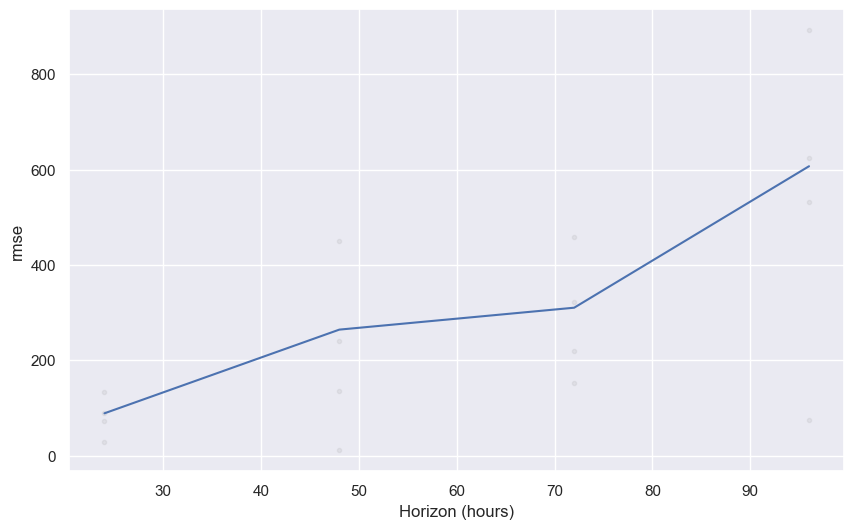

In [337]:
plot_cross_validation_metric(df_cv_b2, 'rmse');

Kita bisa melihat bahwa model kita tidak reliable semakin hari berlalu.

In [388]:
future_b2 = model_prophet_b2.make_future_dataframe(periods=7)

In [340]:
forecast_b2 = model_prophet_b2.predict(future_b2)

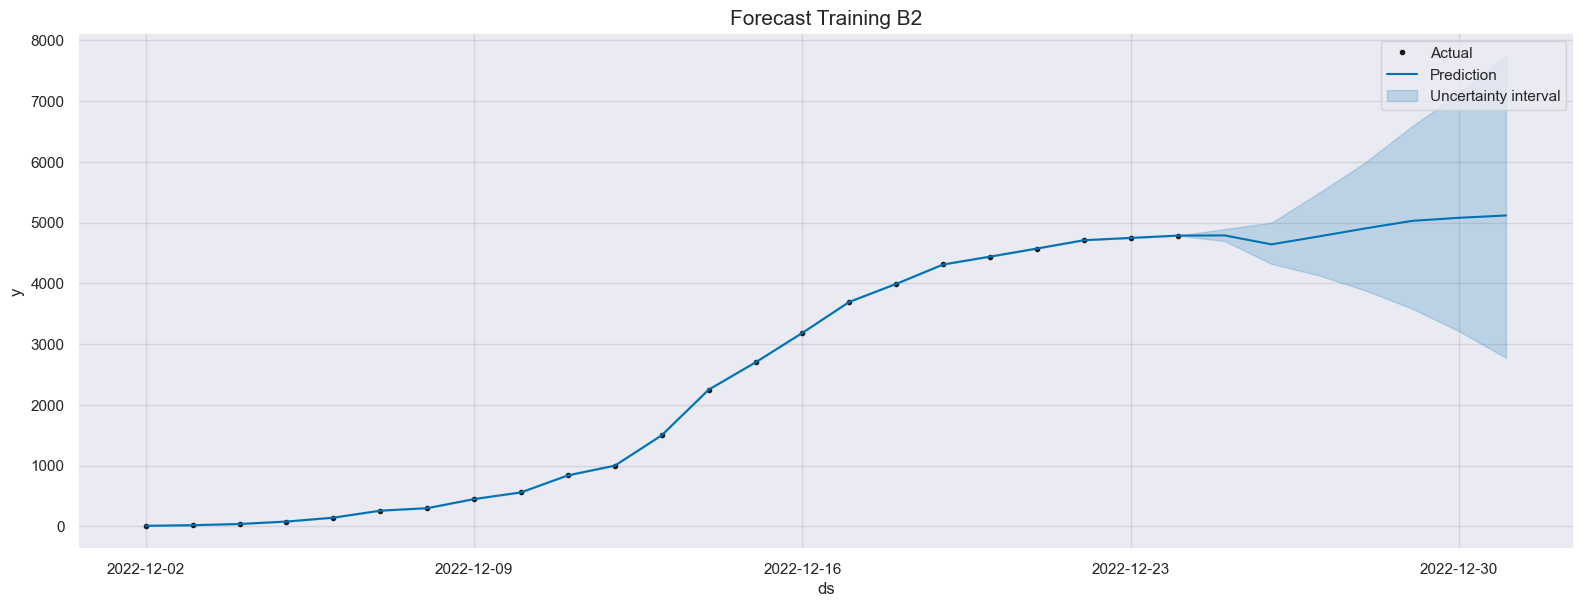

In [419]:
fig = model_prophet_b2.plot(forecast_b2, figsize=(16, 6))
plt.title('Forecast Training B2', size = 15)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.savefig('b2_training_forecast.png', dpi=300);

#### Evaluation

In [342]:
forecast_test_b2 = model_prophet_b2.predict(pd.DataFrame(b2_sales_test.ds))

In [343]:
forecast_test_b2.set_index('ds', inplace=True)

In [344]:
yhat_b2 = forecast_test_b2['yhat']
ytrue_b2 = b2_sales_test['y']

print(f"RMSE: {np.round(rmse(yhat_b2, ytrue_b2),3)}")

RMSE: 157.854


Kita bisa melihat bahwa rmse pada test set jauh di bawah rmse saat training. Hal ini dapat menunjukkan bahwa model kita overfitting.

In [345]:
test_predict_df_b2 = pd.DataFrame({'yhat':yhat_b2,
             'ytrue':b2_sales_test.set_index('ds')['y']})
test_predict_df_b2

,yhat,ytrue
ds,,
2022-12-25,4789.190274,4824.413700
2022-12-26,4641.791169,4863.009010
2022-12-27,4771.113506,4901.913082
2022-12-28,4904.315455,4941.128387
2022-12-29,5028.459484,4980.657414
2022-12-30,5079.197524,4900.000000
2022-12-31,5117.183107,4850.000000


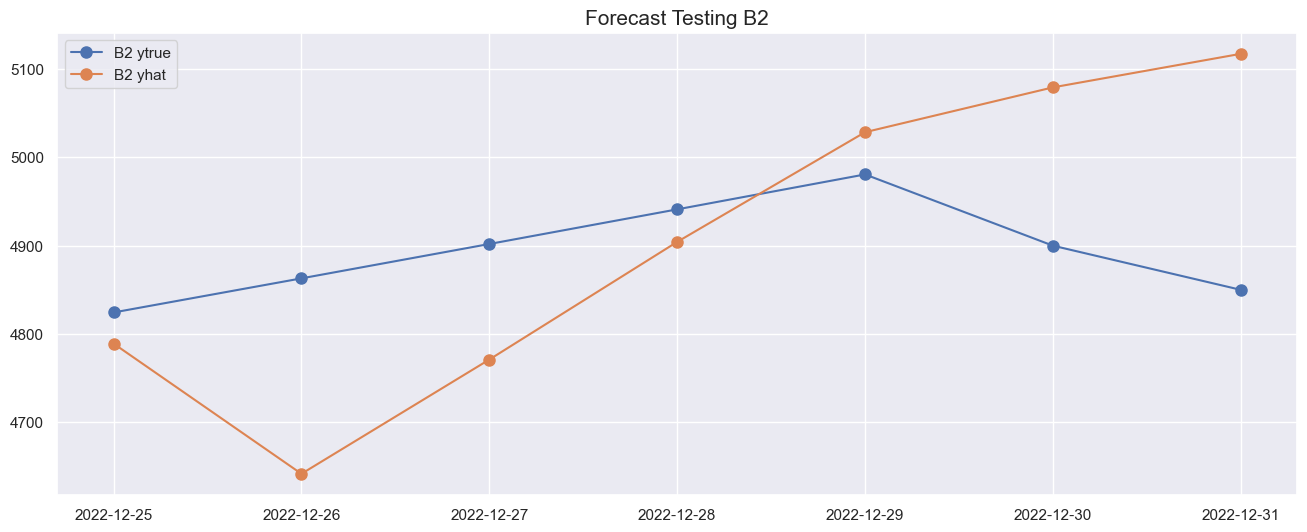

In [418]:
plt.figure(figsize=(16,6))
plt.plot(test_predict_df_b2.ytrue, 'o-', markersize=8, label='B2 ytrue')
plt.plot(test_predict_df_b2.yhat, 'o-', markersize=8, label='B2 yhat')
plt.title('Forecast Testing B2', size = 15)
plt.legend()
plt.savefig('b2_test_forecast.png', dpi=300);

Kita bisa melihat bahwa hasil prediksi masih jauh dari nilai asli sales data tes produk B2. Hal ini mungkin saja disebabkan oleh kurangnya data yang digunakan. Data yang digunakan hanyalah 30 hari untuk training dan testing.

#### Prediksi menggunakan prophet 14 hari ke depan

In [347]:
predict_df_ds_b2 = pd.DataFrame({'ds':pd.date_range('2023-01-01', '2023-01-14')})
predict_df_ds_b2

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
5,2023-01-06
6,2023-01-07
7,2023-01-08
8,2023-01-09
9,2023-01-10


In [348]:
forecast_predict_b2 = model_prophet_b2.predict(predict_df_ds_b2)

In [349]:
forecast_predict_df_b2 = forecast_predict_b2.set_index('ds')

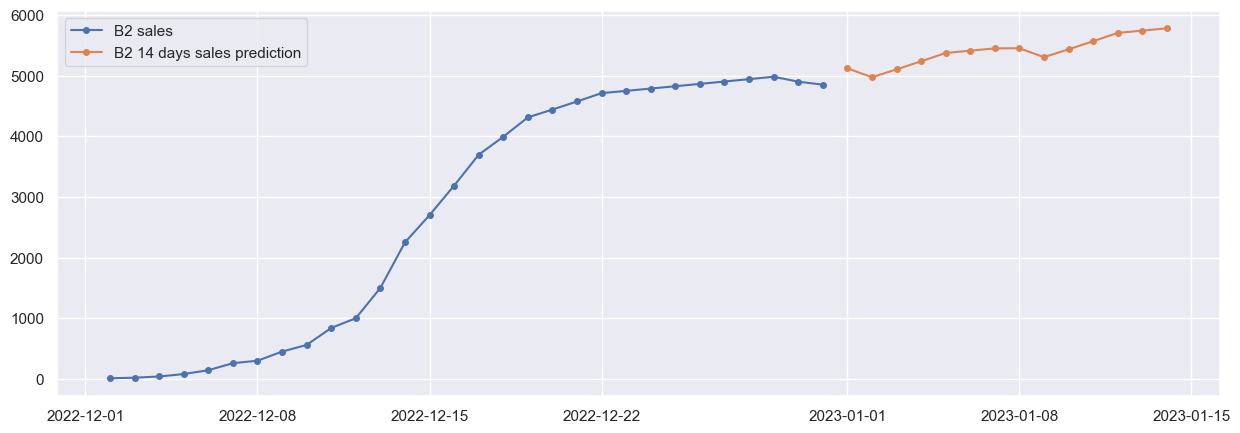

In [406]:
plt.figure(figsize=(15,5))
plt.plot(b2_sales.set_index('ds').y, 'o-', markersize=4, label='B2 sales')
plt.plot(forecast_predict_df_b2.yhat, 'o-', markersize=4, label='B2 14 days sales prediction')
plt.legend()
plt.savefig('b2_prediction_panjang_forecast.png', dpi=300);

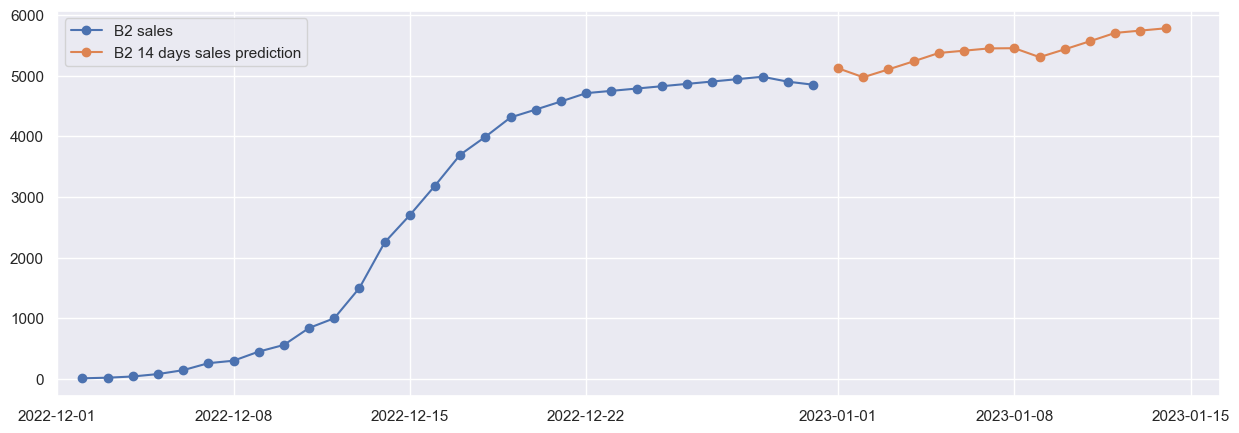

In [407]:
plt.figure(figsize=(15,5))
plt.plot(b2_sales.set_index('ds').y, 'o-', markersize=6, label='B2 sales')
plt.plot(forecast_predict_df_b2.yhat, 'o-', markersize=6, label='B2 14 days sales prediction')
plt.xlim(xmin=datetime.datetime(2022, 12, 1))
plt.legend()
plt.savefig('b2_prediction_panjang_forecast.png', dpi=300);

Kita bisa melihat bahwa hasil prediksi untuk 1 Januari sampai 14 Januari 2023 menunjukkan bahwa sales produk B2 masih mengalami peningkatan bukan penurunan.

#### Save model for A1

In [352]:
with open('model_prophet_b2_infer.json', 'w') as file_1:
    file_1.write(model_to_json(model_prophet_b2))

# Conclusion / Overall Analysis

Untuk produk A1 dan A2 atau kategori A. Model kita masih bisa melakukan prediksi dengan sangat baik karena ada pola yang teratur pada data sales historisnya.  
Untuk produk B1, model kita masih bisa melakukan prediksi dengan baik bukan sangat baik, hal ini disebabkan oleh banyaknya fluktuasi pada produk B1 ini.  
Sedangkan untuk produk B2, model kita tidak melakukan prediksi dengan baik. Hal ini kemungkinan besar disebabkan oleh kurangnya data yang digunakan untuk training.  

Hasil prediksi produk A1, A2, B1, dan B2 menunjukkan bahwa penjualan produk A1, A2, B1 dan B2 akan mengalami penurunan pada tanggal 1 Januari sampai 14 Januari 2023.  
Produk A1 dan A2 masih akan mengalami peningkatan penjualan pada 1 januari sampai 14 Januari 2023.  
Produk B2 juga masih akan mengalami peningkatan penjualan pada 1 januari sampai 14 Januari 2023, namun hasil prediksi ini menurut penulis tidak reliable karena modelnya overfit dan errornya besar.  
Sedangkan produk B1 akan mengalami stagnant.